# Pharmaceutical Reviews - 02b EDA - Pain

In this notebook, I conduct EDA on the reviews for pain medication, primarily using NLP and Sentiment Analysis. As mentioned [here](https://www.cdc.gov/nchs/fastats/drug-use-therapeutic.htm), analgesics, or pain medications, were among the three most frequently prescribed class of medications. Additionally, my experiences as a nutritionist and mental health counselor suggest that pain can be difficult to treat. I explore reviews of pain medication below to see what can be determined which could be useful for improving patient outcomes.

## Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
file_path = '../data/drugsCom_CLEAN.csv'

reviews = pd.read_csv(file_path)

In [3]:
reviews.head()

,drug,condition,review,rating,usefulcount
0,Medroxyprogesterone,Amenorrhea,"""I&#039;m 21 years old and recently found out ...",10.0,11
1,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I have been on the shot 11 years and until a ...",8.0,7
2,Medroxyprogesterone,Birth Control,"""Ive had four shots at this point. I was on bi...",9.0,12
3,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I had a total of 3 shots. I got my first one ...",1.0,4
4,Medroxyprogesterone,Abnormal Uterine Bleeding,"""I&#039;m 18 and got this for heavy bleeding. ...",5.0,6


In [4]:
reviews.shape

(161297, 5)

## Creating the Dataset

In [5]:
#creates a dataframe of the reviews for pain condition & displays top 5 rows

pain = reviews.loc[reviews['condition'] == 'Pain']

pain = pd.DataFrame(pain)

pain.head()

,drug,condition,review,rating,usefulcount
1043,Ibudone,Pain,"""I just started taking this medicine. I have ...",7.0,27
1048,Ultram ODT,Pain,"""You can use ultram to detox yourself from har...",10.0,28
1053,Ultram ODT,Pain,"""I have been using tramadol for eight years fo...",10.0,105
1944,Belbuca,Pain,"""I was on Fentynal patches for year and a hal...",1.0,14
2110,Talacen,Pain,"""I have rheumatoid arthritis and a few other b...",9.0,12


In [6]:
pain.shape

(6145, 5)

In [7]:
pain.isnull().sum()

drug           0
condition      0
review         0
rating         0
usefulcount    0
dtype: int64

In [8]:
pain.condition.unique() 

array(['Pain'], dtype=object)

All conditions are correctly listed as "Pain." I will now remove the condition column as it is no longer needed.

In [9]:
#drops condition column & shows revised list of columns

pain = pain.drop(columns = ['condition'])

pain.columns

Index(['drug', 'review', 'rating', 'usefulcount'], dtype='object')

In [10]:
pain.head()

,drug,review,rating,usefulcount
1043,Ibudone,"""I just started taking this medicine. I have ...",7.0,27
1048,Ultram ODT,"""You can use ultram to detox yourself from har...",10.0,28
1053,Ultram ODT,"""I have been using tramadol for eight years fo...",10.0,105
1944,Belbuca,"""I was on Fentynal patches for year and a hal...",1.0,14
2110,Talacen,"""I have rheumatoid arthritis and a few other b...",9.0,12


This dataframe is now ready to use.

Ultimately, I would like to compare reviews that contain the highest and lowest ratings. First, I will observe a statistical summary to gain information about the ratings.

In [11]:
pain.rating.describe() #shows a statistical summary

count    6145.000000
mean        7.632221
std         2.928199
min         1.000000
25%         7.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

It appears that the median is at 9.0. I will re-display the histogram of review ratings for the pain condition.

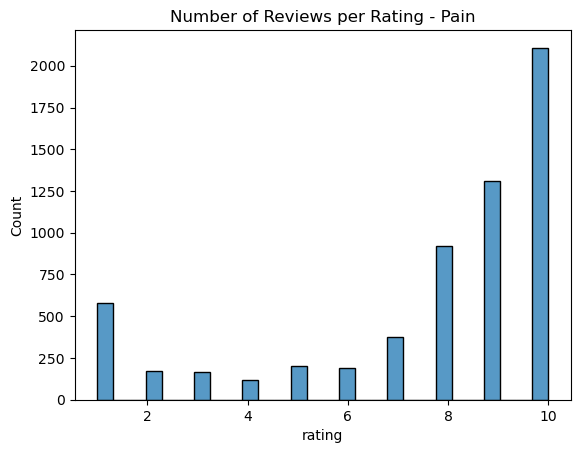

In [12]:
sns.histplot(data = pain, x='rating').set(title = 'Number of Reviews per Rating - Pain');

In [13]:
pain.rating.median()

9.0

From my perspective, a median rating of 9.0 suggests an overall high level of satisfaction being expressed in the reviews for pain medication.

However, there is room for improvement, as there are a number of reviews below 5, indicating dissatisfaction.

First, I will oberve for differences between the reviews with ratings of 10 to reviews with ratings of 1.

## Creating Subsets

#### Reviews Rated 10

In [14]:
# creates a subset of pain with only 10-rated reviews

ten = pain.loc[pain['rating'] == 10]

ten = pd.DataFrame(ten)

ten.head()

,drug,review,rating,usefulcount
1048,Ultram ODT,"""You can use ultram to detox yourself from har...",10.0,28
1053,Ultram ODT,"""I have been using tramadol for eight years fo...",10.0,105
2500,Lorcet 10 / 650,"""This pill has allowed me to get some much nee...",10.0,9
2891,Codeine,"""I was prescribed codeine when my wisdom teeth...",10.0,11
2894,Codeine,"""Very effective. I have osteoarthritis and can...",10.0,59


In [15]:
ten.shape

(2108, 4)

There are 2108 reviews with a rating of 10 for the pain condition.

In [16]:
ten.rating.unique()

array([10.])

It appears the subset was made correctly. Before using NLP, I will examine other attributes of this subset.

In [17]:
ten.usefulcount.mean()

41.55075901328273

Mean useful count of reviews for this group is 41.55.

In [18]:
ten.drug.value_counts()

Oxycodone                      132
Acetaminophen / oxycodone      107
Acetaminophen / hydrocodone    106
Hydromorphone                  100
Dilaudid                        88
                              ... 
Fentora                          1
Oxyfast                          1
Methadone Diskets                1
Orudis KT                        1
Soma Compound with Codeine       1
Name: drug, Length: 160, dtype: int64

There are 160 drugs with at least 1 10-star review for pain. Drugs most commonly rated 10 for the pain condition are: Oxycodone, Acetaminophen / oxycodone, Acetaminophen / hydrocodone, Hydromorphone, and Dilaudid.

I will now use NLP to examine words within this subset.

I will begin by looking for the most common single words in the reviews.

#### Reviews Rated 1

In [19]:
# creates a subset of pain with only 10-rated reviews

one = pain.loc[pain['rating'] == 1]

one = pd.DataFrame(one)

one.head()

,drug,review,rating,usefulcount
1944,Belbuca,"""I was on Fentynal patches for year and a hal...",1.0,14
2556,Darvocet A500,"""I have Anklosing spondylitis, arthritis in ma...",1.0,19
2890,Codeine,"""Had Panadeine Forte for a tooth abscess pain....",1.0,14
2892,Codeine,"""My dentist prescribed it to me to treat a too...",1.0,19
2906,Codeine,"""I had an external hemorrhoids surgery and cod...",1.0,2


In [20]:
one.shape

(582, 4)

There are 582 reviews rated 1 for the pain condition.

In [21]:
2108/582 #of 10 rated reviews / # of 1 rated reviews

3.6219931271477663

There are more than 3x as many 10-rated reviews than 1-rated reviews for the pain condition.

In [22]:
one.rating.unique()

array([1.])

The subset has been created. I will observe a few attributes before moving on to NLP.

In [23]:
one.usefulcount.mean() 

22.572164948453608

The mean useful count of the 1-rated reviews is 22.57.

In [24]:
ten.usefulcount.mean()/one.usefulcount.mean()

1.8407963572908996

The mean useful count of the 10 reviews is almost 2x that of the 1 reviews.

In [25]:
one.drug.value_counts()

Tramadol                   62
Tapentadol                 40
Acetaminophen / codeine    29
Gabapentin                 28
Nucynta                    28
                           ..
Morphine / naltrexone       1
Duragesic                   1
Avinza                      1
OxyContin                   1
Camphor / menthol           1
Name: drug, Length: 102, dtype: int64

There are 102 drugs that were given a 1-star rating at least once. Drugs most commonly given a 1-rated review for pain are: Tramadol, Tapentadol, Acetaminophen / codeine, Gabapentin, and Nucynta.

I will now move on to use NLP to observe most common unigrams, bigrams, and trigrams.

## 10-Rated v. 1-Rated

### Unigrams

In [26]:
review_stop_words = text.ENGLISH_STOP_WORDS.union(["039" ,"ve"])

In [27]:
len(review_stop_words)

320

##### Reviews Rated 10

In [28]:
cvx = CountVectorizer(stop_words = review_stop_words) #converts each review word into a column to create a dataframe
cvx.fit(ten['review'])

ten_cvx = cvx.transform(ten['review'])
ten_cvx = pd.DataFrame(ten_cvx.todense(), columns = cvx.get_feature_names_out())

In [29]:
ten_cvx.shape #displays layout of dataframe

(2108, 5363)

In [30]:
ten_cvx.sum().sort_values(ascending = False).head(20) #shows 20 most common words in reviews

pain          3740
day            698
years          665
life           508
medicine       488
doctor         482
taking         434
medication     395
works          362
relief         362
severe         352
effects        336
like           328
work           316
10             314
worked         312
great          304
just           304
time           302
hours          300
dtype: int64

##### Reviews Rated 1

In [31]:
cvx = CountVectorizer(stop_words = review_stop_words) #converts each review word into a column to create a dataframe
cvx.fit(one['review'])

one_cvx = cvx.transform(one['review'])
one_cvx = pd.DataFrame(one_cvx.todense(), columns = cvx.get_feature_names_out())

In [32]:
one_cvx.shape #displays layout of dataframe

(582, 2784)

In [33]:
one_cvx.sum().sort_values(ascending = False).head(20) #shows 20 most common words in reviews

pain          790
day           159
medication    147
taking        138
relief        134
did           126
took          124
prescribed    121
doctor        111
time          106
work          102
hours         101
like           95
given          90
just           88
help           87
effects        85
severe         85
medicine       82
mg             81
dtype: int64

The most common unigrams appear fairly similar between the two different rating sets.

Bigrams may be more revealing. I will explore these next.

### Bigrams

##### Reviews Rated 10

In [34]:
#converts each title bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=review_stop_words, ngram_range=(2,2))

cv_bigrams.fit(ten['review'])

ten_cv_bigrams= cv_bigrams.transform(ten['review'])
ten_cv_bigrams= pd.DataFrame(ten_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [35]:
ten_cv_bigrams.shape

(2108, 31630)

In [36]:
ten_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

chronic pain         162
pain relief          155
pain free            125
severe pain          118
times day             95
pain away             86
pain management       85
breakthrough pain     84
years ago             77
pain medication       73
10 325                67
pain medicines        66
doctor gave           61
pain medicine         61
pain gone             60
best pain             60
life saver            58
quality life          57
works great           56
pain years            52
dtype: int64

By using two words, themes begin to emerge. I suspect that terms such as "pain gone," "best pain," "life saver," "quality life," and "works great" will not be found among the most common in the 1-star review set. 

I will observe below.

##### Reviews Rated 1

In [37]:
#converts each bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=review_stop_words, ngram_range=(2,2))

cv_bigrams.fit(one['review'])

one_cv_bigrams= cv_bigrams.transform(one['review'])
one_cv_bigrams= pd.DataFrame(one_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [38]:
one_cv_bigrams.shape

(582, 10048)

In [39]:
one_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

pain relief          59
chronic pain         25
help pain            24
times day            21
pain management      21
severe pain          18
felt like            17
does work            16
pain medication      16
waste money          16
doctor prescribed    16
relieve pain         15
did help             14
does absolutely      14
did absolutely       14
lidocaine patches    13
didn work            13
doesn help           13
opana er             13
severe headache      12
dtype: int64

Here, certain terms emerge that were not found in the 10-review's most common bigrams, such as "waste money," "didn('t) work," and "doesn('t) help."

I also suspsect that bigrams such as "does absolutely," and "did absolutely" may end with the word "nothing," or something similar that would be more revealing.

I will explore trigrams below.

### Trigrams

##### Reviews rated 10

In [40]:
cv_trigrams = CountVectorizer(stop_words=review_stop_words, ngram_range=(3,3))

cv_trigrams.fit(ten['review'])

ten_cv_trigrams= cv_trigrams.transform(ten['review'])
ten_cv_trigrams= pd.DataFrame(ten_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [41]:
ten_cv_trigrams.shape

(2108, 40022)

In [42]:
ten_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most trigrams in reviews

degenerative disc disease    40
took pain away               35
norco 10 325                 28
takes pain away              25
pain management doctor       21
best pain reliever           17
percocet 10 325              15
quot high quot               14
mg times day                 13
best pain medication         12
took away pain               11
best pain medicine           11
gets rid pain                10
years chronic pain           10
improved quality life         9
really helps pain             9
live normal life              9
pain 12 years                 9
chronic pain years            9
takes away pain               9
dtype: int64

This set is the most revealing yet, with terms such as "took pain away," "best pain reliever," "best pain medication," "took away pain," "best pain medicine," "gets rid pain," and more.

I will observe the trigrams within the 1-rated reviews.

##### Reviews rated 1

In [43]:
cv_trigrams = CountVectorizer(stop_words=review_stop_words, ngram_range=(3,3))

cv_trigrams.fit(one['review'])

one_cv_trigrams= cv_trigrams.transform(one['review'])
one_cv_trigrams= pd.DataFrame(one_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [44]:
one_cv_trigrams.shape

(582, 11114)

In [45]:
one_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most trigrams in reviews

given dilaudid iv          8
waste time money           7
pain management doctor     6
doctor wanted try          6
does absolutely pain       5
did help pain              5
dr wanted try              4
wisdom tooth pain          4
better good luck           4
didn help pain             4
didn make dent             4
little pain relief         4
20 mg month                4
tramadol 50mg hours        4
30 minutes later           4
make dent pain             4
severe headache nausea     4
experienced pain relief    4
ibuprofen worked better    3
like taking placebo        3
dtype: int64

Here, common trigrams include: "waste time money," "didn't help pain," "didn't make dent," "little pain relief," "severe headache nausea," and "like taking placebo," among others.

The most frequent trigram is a specific reference to a dilaudid iv.

I will learn more about the reviews of this specific drug, among others, below.

### Sentiment Analysis

In [46]:
sia = SentimentIntensityAnalyzer()

##### Reviews Rated 10

In [47]:
scores10 = [sia.polarity_scores(word) for word in ten['review']]

scores10_sentiments = pd.DataFrame(scores10)

In [48]:
scores10_sentiments.head()

,neg,neu,pos,compound
0,0.081,0.741,0.178,0.4939
1,0.195,0.777,0.028,-0.9141
2,0.142,0.756,0.102,-0.6597
3,0.098,0.791,0.111,0.1779
4,0.145,0.589,0.266,0.9257


In [49]:
scores10_sentiments.describe()

,neg,neu,pos,compound
count,2108.000000,2108.000000,2108.000000,2108.000000
mean,0.145992,0.732185,0.121828,-0.184345
std,0.094339,0.134357,0.111674,0.635321
min,0.000000,0.076000,0.000000,-0.995100
25%,0.084750,0.674000,0.054000,-0.795725
50%,0.139000,0.750000,0.100000,-0.317300
75%,0.198000,0.815250,0.160000,0.415800
max,0.767000,1.000000,0.804000,0.987800


For the 10-Rated Reviews, Mean scores =

Negative: 0.145992
Neutral: 0.732185
Positive: 0.121828
Compound: -0.184345

The mean compound score is slightly negative, meaning the language used is slightly more negative. 

I will complete the same process for the 1-Rated reviews as a basis of comparison.

##### Reviews Rated 1

In [50]:
scores1 = [sia.polarity_scores(word) for word in one['review']]

scores1_sentiments = pd.DataFrame(scores1)

In [51]:
scores1_sentiments.head()

,neg,neu,pos,compound
0,0.092,0.834,0.075,-0.2298
1,0.000,0.948,0.052,0.0951
2,0.356,0.644,0.000,-0.7351
3,0.000,0.816,0.184,0.4019
4,0.063,0.937,0.000,-0.2235


In [52]:
scores1_sentiments.describe()

,neg,neu,pos,compound
count,582.000000,582.000000,582.000000,582.000000
mean,0.171107,0.750041,0.078859,-0.458895
std,0.103491,0.118542,0.078238,0.508689
min,0.000000,0.104000,0.000000,-0.990900
25%,0.104000,0.685000,0.018000,-0.868850
50%,0.161000,0.764000,0.067000,-0.679700
75%,0.230750,0.821000,0.112000,-0.137150
max,0.644000,1.000000,0.556000,0.977500


For the 1 Rated Reviews, Mean scores = 

Negative: 0.171107
Neutral: 0.750041
Positive: 0.078859
Compound: -0.458895

The mean compound score is moderately negative, more strongly negative than the mean score for the reviews rated 10.

### Samples

It may be of interest to look more closely at some of the reviews in order to see what praise and/or concerns patients have when taking these medications. I will observe below.

##### 10 Reviews

In [53]:
ten.sample(1, random_state = 1234).values.tolist()

[['Buprenorphine',
  '"At age 55 I fell off the roof and I had pain in my tail bone. Nothing showed on X-ray, CAT scan, MRI&#039;S either. So I was given hydrocodone and tylenol 3, a pat on the head and was basically told to suffer.  Surgery was denied, I was in so much pain I didn&#039;t care. All the medical society abandoned me. So one day I said good by and took all the pills I could find and tried to commit suicide. Didn&#039;t work, sent to psyc. ward and started on buprenorphine. What a God send. I have been mostly pain free for 6 years. Yea I&#039;m &#039;hooked&#039; but I am so blessed for it. ps. I am also &#039;hooked&#039; on insulin. Dependent not addicted."',
  10.0,
  28]]

This reviewer describes buprenorphine as a "God send," stating it relieved pain that was severe enough that the person previously tried to commit suicide.

In [54]:
ten.sample(1, random_state = 3456).values.tolist()

[['Oxycodone',
  '"This medicine has worked wonders on my chronic back pain. I have tried everything from Tramadol to Opana ER and for the price Roxicodone 30mg tops them all if taken as prescribed, and at the same time each day. The only downfall is that you must take the pills more frequently than say MS Contin or Oxycontin where you only need them every 12 hours. However that was my main problem with the Opana, Oxycontin, Etc., they didn&#039;t seem to last the full 12 hours as advertised. I was lucky if I got a good 8 hours from them."',
  10.0,
  48]]

Regarding Oxycodone, this person informs, "This medicine has worked wonders on my back pain."

In [55]:
ten.sample(1, random_state = 6789).values.tolist()

[['Naproxen',
  '"52 yr old struggled physically for 30 years, fibromyalgia, CFS, widespread joint and muscle pain.\r\nDepressed due to daily pain and effort to do anything.\r\nTook 500mg Naproxen and the pain, stiffness and burning has virtually gone, it took about 45 minutes to work, I feel like somebody else, woke up this morning having had a good nights sleep still feeling much better, I can&#039;t actually believe it. Ibuprofen, paracetamol didn&#039;t touch it, Zapain helps but worsens fatigue.\r\nI was prescribed Naproxen 6 months ago 250 mg twice a day, didn&#039;t do a lot and I over read and over thought the side effects so didn&#039;t bother. I&#039;m trying 500 mg once a day for a few days then I&#039;ll try splitting the dose. I&#039;ve had no side effects on either 500mg so far, I just feel great."',
  10.0,
  5]]

Regarding Naproxen, this person informs, "Took 500mg Naproxen and the pain, stiffness and burning has virtually gone...had a good nights sleep still feeling much better."

##### Sentiment Analysis

Below, I will create a dataframe of sentiment scores to add to the main dataframe, and then create barplots.

In [56]:
#creating a dataframe of the reviews

sample10 = pd.concat([ten.sample(1, random_state = 1234), ten.sample(1, random_state = 3456),
                     ten.sample(1, random_state = 6789)])
                      
sample10

,drug,review,rating,usefulcount
48421,Buprenorphine,"""At age 55 I fell off the roof and I had pain ...",10.0,28
131834,Oxycodone,"""This medicine has worked wonders on my chroni...",10.0,48
60935,Naproxen,"""52 yr old struggled physically for 30 years, ...",10.0,5


In [57]:
#creating a list of reviews

words10 = sample10.review.values.tolist()

words10_df = pd.DataFrame(words10)

words10_df

,0
0,"""At age 55 I fell off the roof and I had pain ..."
1,"""This medicine has worked wonders on my chroni..."
2,"""52 yr old struggled physically for 30 years, ..."


In [58]:
#generating sentiment scores & creating a dataframe of the sentiment scores with their reviews

scores_s10 = [sia.polarity_scores(word) for word in sample10['review']]

scores_s10_sentiments = pd.DataFrame(scores_s10)

final_s10_sentiments = pd.concat([words10_df, scores_s10_sentiments], axis=1)

final_s10_sentiments

,0,neg,neu,pos,compound
0,"""At age 55 I fell off the roof and I had pain ...",0.119,0.755,0.126,0.4473
1,"""This medicine has worked wonders on my chroni...",0.058,0.856,0.087,0.4588
2,"""52 yr old struggled physically for 30 years, ...",0.161,0.779,0.060,-0.9389


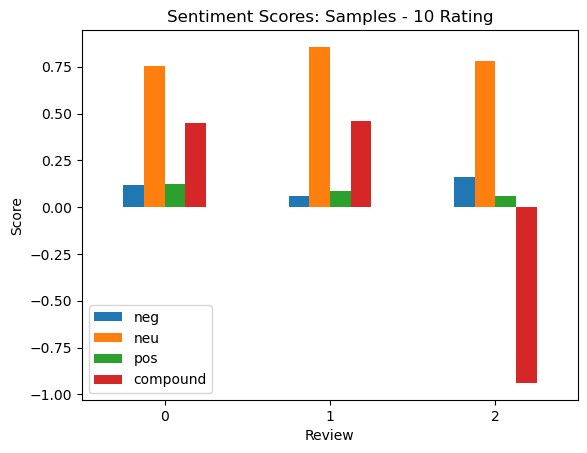

In [59]:
#creating a bar plot of the sentiment scores

final_s10_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - 10 Rating', xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

Two of the reviews have positive compound scores, while one review has a negative compound score.

I will compare this to the plot of the reviews with ratings of 1, which I will determine below.

##### 1 Reviews

In [60]:
one.sample(1, random_state = 2424).values.tolist()

[['Hysingla ER',
  '"I&#039;ve been a chronic pain patient for 10 plus years. My dr wanted me to try Hysingla 100 mg even though my other medication was working the best out of all the others I&#039;ve tried and been on.  I took the first does and I didn&#039;t seem to have any relief but I kept reminding myself what he and I discussed so I gave it another try.  By this time my other medication is no longer in my system and now my pain is getting really bad so I called my dr&#039;s office. I was advised that the Hysingla would peak at 15 hours of taking it and sometimes takes a while to build up.  After a few days my dr took me off of it, an asprin worked better then the Hysingla.  I hope others don&#039;t have to suffer like I did."',
  1.0,
  52]]

Regarding Hyslinga ER, this patient informs they didn't "seem to have any relief."

In [61]:
one.sample(1, random_state = 4646).values.tolist()

[['Gabapentin',
  '"I have very little memory of my time taking Gabapentin - which is part of the problem with the drug.  For some people it&#039;s OK, but for me my memory from that time is like a black hole.  I remember starting it, a few flashes while taking it, but I don&#039;t remember tapering off the drug.  It&#039;s like I lost 6 months of my life.  I couldn&#039;t even tell you if it helped with the pain."',
  1.0,
  49]]

This person reports memory concerns while taking Gabapentin, stating, "It's like I lost 6 months of my life. I couldn't even tell you if it helped with the pain."

In [62]:
one.sample(1, random_state = 4848).values.tolist()

[['Diclofenac',
  '"I actually came on this site to read about Voltaren gel to see if its effects were supposed to be cumulative--if, that is, I was supposed to start getting relief after several applications of the gel.  Unfortunately, I found out that it is supposed to work to relieve the pain each time it is used.  It certainly doesn&#039;t do this for me--I may as well be applying lotion for all the good it does me.  It really does nothing at all.\r\n\r\nI&#039;m really disappointed, as my pain management doctor just weaned me off of narcotics, so I don&#039;t have anything that helps with the pain at the moment.  I&#039;ll have to go see him again to get something else. It is so frustrating to try to find something that works, since everyone is different."',
  1.0,
  29]]

Regarding Diclofenac, this patient states, "It really does nothing at all," also informing that he is disappointed as his pain management doctor just weaned him off of narcotics.

##### Sentiment Analysis

In [63]:
#creating a dataframe of the sample reviews

sample1 = pd.concat([one.sample(1, random_state = 2424), one.sample(1, random_state = 4646),
                     one.sample(1, random_state = 4848)])
                      
sample1

,drug,review,rating,usefulcount
57466,Hysingla ER,"""I&#039;ve been a chronic pain patient for 10 ...",1.0,52
78256,Gabapentin,"""I have very little memory of my time taking G...",1.0,49
125534,Diclofenac,"""I actually came on this site to read about Vo...",1.0,29


In [64]:
# creating a list of reviews

words1 = sample1.review.values.tolist()

words1_df = pd.DataFrame(words1)

words1_df

,0
0,"""I&#039;ve been a chronic pain patient for 10 ..."
1,"""I have very little memory of my time taking G..."
2,"""I actually came on this site to read about Vo..."


In [65]:
#generating sentiment scores & turning them into a dataframe with the reviews

scores_s1 = [sia.polarity_scores(word) for word in sample1['review']]

scores_s1_sentiments = pd.DataFrame(scores_s1)

final_s1_sentiments = pd.concat([words1_df, scores_s1_sentiments], axis=1)

final_s1_sentiments


,0,neg,neu,pos,compound
0,"""I&#039;ve been a chronic pain patient for 10 ...",0.124,0.776,0.100,-0.6946
1,"""I have very little memory of my time taking G...",0.063,0.826,0.111,0.5671
2,"""I actually came on this site to read about Vo...",0.126,0.773,0.101,-0.7035


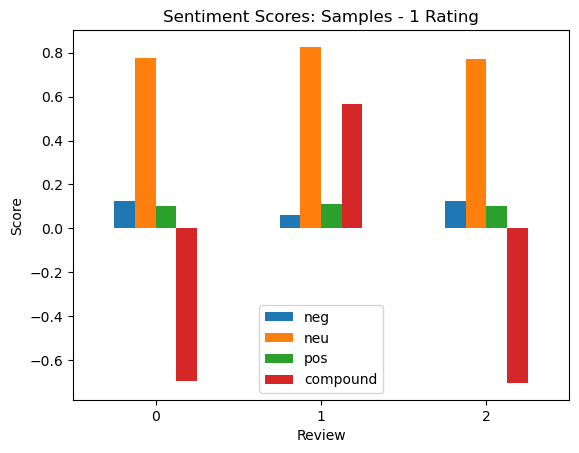

In [66]:
#creating a barplot of sentiment scores for each review

final_s1_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - 1 Rating', xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

While the 10 rating group contained only 1 review with a negative compound score, the 1 rating group had 2 reviews with negative compound scores.

This information could be used, for example, to help create a way to differentiate between positive and negative reviews using the language.

I will continue to observe patterns in language and sentiment scores as I analyze additional subsets below.

## Alternative Subsets

Next, I would like to observe the differences in language used in reviews for drugs which have a high number of 10 ratings, versus reviews for drugs which have a high number of 1 ratings.

I will begin by creating the subsets below.

### Drugs Commonly Given Ratings of 10

In [67]:
ten.drug.value_counts() #shows drugs with highest number of 10 ratings (top 5 on list)

Oxycodone                      132
Acetaminophen / oxycodone      107
Acetaminophen / hydrocodone    106
Hydromorphone                  100
Dilaudid                        88
                              ... 
Fentora                          1
Oxyfast                          1
Methadone Diskets                1
Orudis KT                        1
Soma Compound with Codeine       1
Name: drug, Length: 160, dtype: int64

In [68]:
#creates a subset of the pain dataframe with only the drugs of interest

ten_common = pain.loc[(pain['drug'] == 'Oxycodone') | (pain['drug'] == 'Acetaminophen / oxycodone') |
                     (pain['drug'] == 'Acetaminophen / hydrocodone')|(pain['drug'] == 'Hydromorphone')|
                    (pain['drug'] == 'Dilaudid')]

ten_common.head()

,drug,review,rating,usefulcount
28361,Acetaminophen / oxycodone,"""I think endocet are the best pain medicine I...",10.0,19
28367,Acetaminophen / oxycodone,"""Taking for tooth abscesses , on 2 days now . ...",1.0,5
28369,Acetaminophen / oxycodone,"""I had either an abscess tooth and/or nerve ex...",10.0,8
28372,Acetaminophen / oxycodone,"""My doc prescribed this for after having colit...",1.0,9
28375,Acetaminophen / oxycodone,"""This is the only narcotic for pain that does ...",8.0,13


In [69]:
ten_common.drug.unique()

array(['Acetaminophen / oxycodone', 'Hydromorphone',
       'Acetaminophen / hydrocodone', 'Dilaudid', 'Oxycodone'],
      dtype=object)

This has the correct drugs within. I will proceed with further analysis.

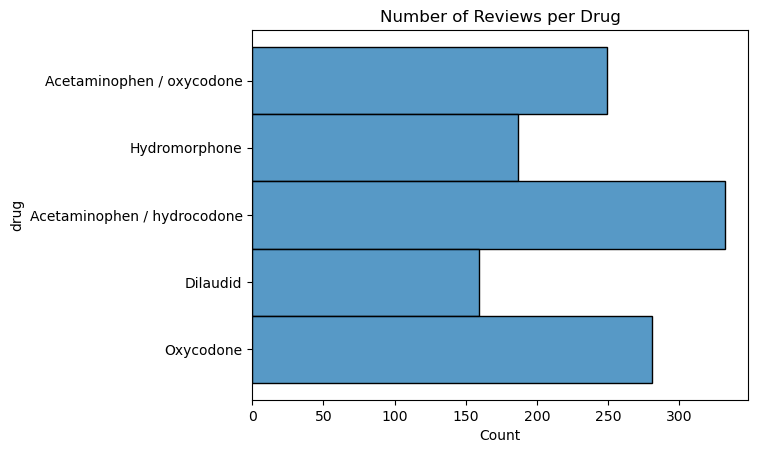

In [70]:
sns.histplot(data = ten_common, y='drug').set(title = 'Number of Reviews per Drug');

In [71]:
ten_common.shape

(1208, 4)

There are 1208 reviews within this subset.

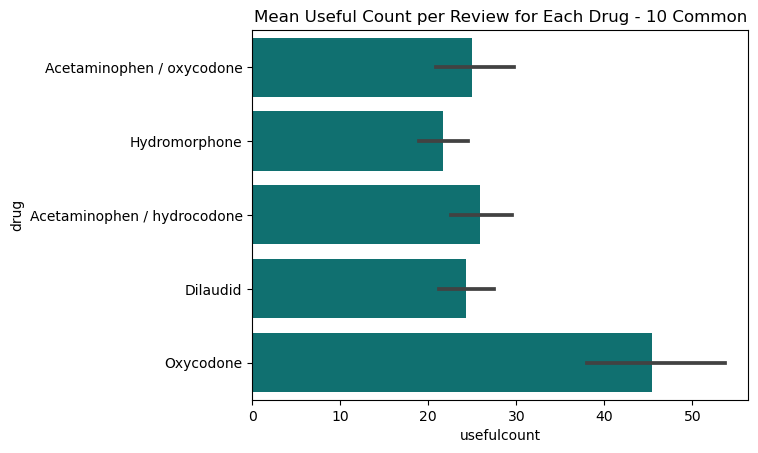

In [72]:
sns.barplot(data= ten_common, x='usefulcount', y='drug', orient = 'h', color = 'teal').set(
    title = 'Mean Useful Count per Review for Each Drug - 10 Common');

The Oxycodone reviews have the highest average useful count.

In [73]:
ten_common.usefulcount.describe()

count    1208.000000
mean       29.373344
std        42.610844
min         0.000000
25%         9.000000
50%        18.000000
75%        33.000000
max       463.000000
Name: usefulcount, dtype: float64

This subset has a mean useful count of 29.37.

In [74]:
ten_common.groupby('drug')['usefulcount'].mean()

drug
Acetaminophen / hydrocodone    25.882530
Acetaminophen / oxycodone      24.943775
Dilaudid                       24.270440
Hydromorphone                  21.631016
Oxycodone                      45.462633
Name: usefulcount, dtype: float64

In [75]:
ten_common.rating.describe()

count    1208.000000
mean        8.389901
std         2.333318
min         1.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: rating, dtype: float64

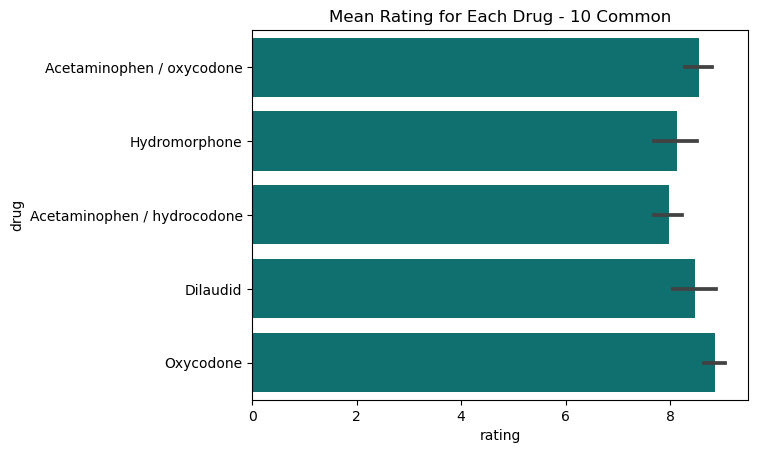

In [76]:
sns.barplot(data= ten_common, x='rating', y='drug', orient = 'h', color = 'teal').set(
    title = 'Mean Rating for Each Drug - 10 Common');

In [77]:
ten_common.groupby('drug')['rating'].mean()

drug
Acetaminophen / hydrocodone    7.975904
Acetaminophen / oxycodone      8.546185
Dilaudid                       8.484277
Hydromorphone                  8.133690
Oxycodone                      8.857651
Name: rating, dtype: float64

The mean ratings for each drug are shown above, all approximately 8 or higher.

Next, I will observe information for drugs with a high number of reviews rated 1.

### Drugs Commonly Given Ratings of 1

In [78]:
one.drug.value_counts() #shows drugs with the highest number of 1 ratings (top 5 on list)

Tramadol                   62
Tapentadol                 40
Acetaminophen / codeine    29
Gabapentin                 28
Nucynta                    28
                           ..
Morphine / naltrexone       1
Duragesic                   1
Avinza                      1
OxyContin                   1
Camphor / menthol           1
Name: drug, Length: 102, dtype: int64

In [79]:
one_common = pain.loc[(pain['drug'] == 'Tramadol') | (pain['drug'] == 'Tapentadol') |
                     (pain['drug'] == 'Acetaminophen / codeine')|(pain['drug'] == 'Gabapentin')|
                    (pain['drug'] == 'Nucynta')]

one_common.head()

,drug,review,rating,usefulcount
14312,Nucynta,"""I have severe, constant pain following 4 seri...",5.0,29
14313,Nucynta,"""This has worked great for me. Manages my pain...",8.0,31
14314,Nucynta,"""I have severe IC. This is the only Med that m...",8.0,22
14315,Nucynta,"""I have a form of muscular dystrophy and take ...",10.0,26
14316,Nucynta,"""DO NOT TAKE THIS PILL...!!\r\nIF YOU HAVE ANY...",1.0,33


In [80]:
one_common.shape

(1007, 4)

There are 1007 reviews within this subset, somewhat less than in the 10 common group.

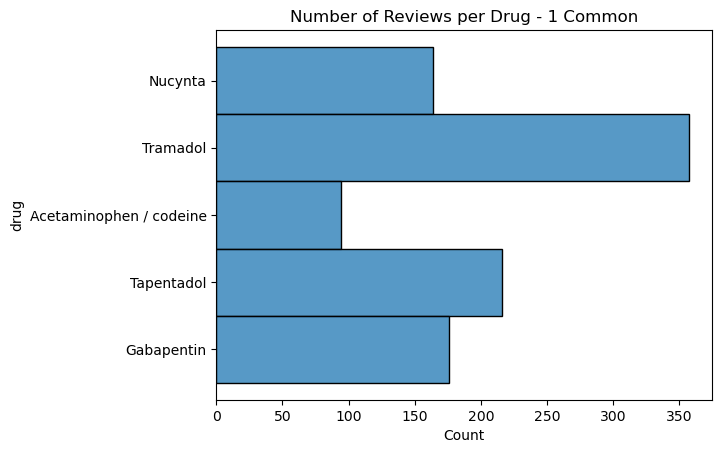

In [81]:
sns.histplot(data= one_common, y='drug').set(title = 'Number of Reviews per Drug - 1 Common');

In [82]:
one_common.drug.value_counts()

Tramadol                   357
Tapentadol                 216
Gabapentin                 176
Nucynta                    164
Acetaminophen / codeine     94
Name: drug, dtype: int64

In [83]:
one_common.rating.describe()

count    1007.000000
mean        6.310824
std         3.321074
min         1.000000
25%         3.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: rating, dtype: float64

Mean rating for this subset is 6.31, and the median is 8.00. These values are lower than for the 10 common subset.

In [84]:
one_common.usefulcount.describe()

count    1007.000000
mean       37.219464
std        38.293111
min         0.000000
25%        13.500000
50%        25.000000
75%        49.000000
max       317.000000
Name: usefulcount, dtype: float64

Mean useful count for these reviews is 37.21, and a median of 25.00. These values are higher than those in the 1 common dataset.

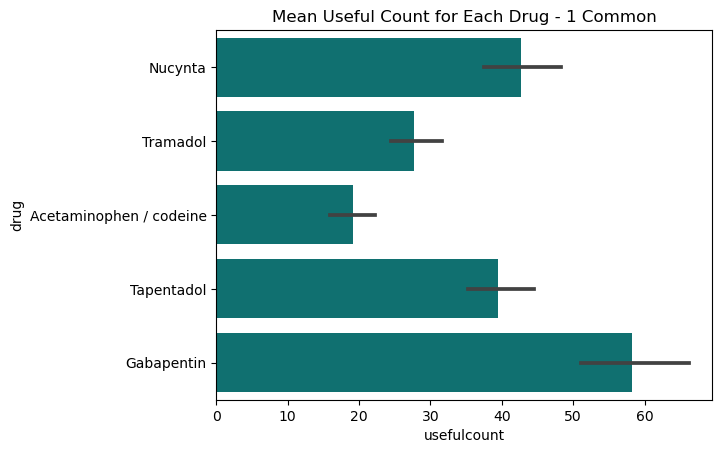

In [85]:
sns.barplot(data= one_common, x='usefulcount', y='drug', orient = 'h', color = 'teal').set(
    title= 'Mean Useful Count for Each Drug - 1 Common');

In [86]:
one_common.groupby('drug')['usefulcount'].mean()

drug
Acetaminophen / codeine    19.095745
Gabapentin                 58.250000
Nucynta                    42.713415
Tapentadol                 39.449074
Tramadol                   27.750700
Name: usefulcount, dtype: float64

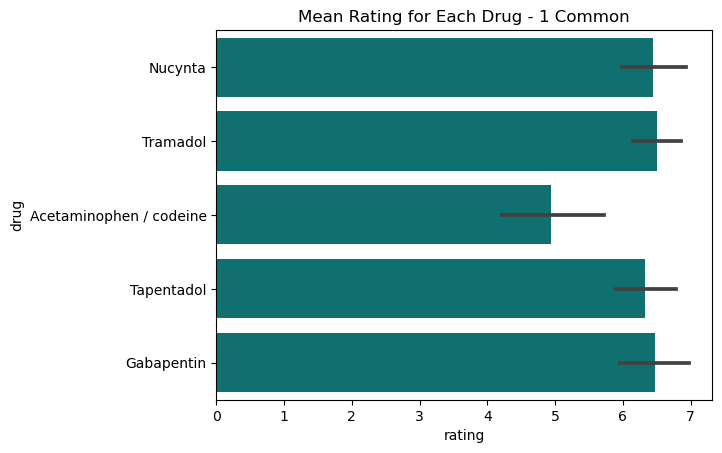

In [87]:
sns.barplot(data = one_common, x='rating', y='drug', orient = 'h', color = 'teal').set(
    title = 'Mean Rating for Each Drug - 1 Common');

In [88]:
one_common.groupby('drug')['rating'].mean()

drug
Acetaminophen / codeine    4.946809
Gabapentin                 6.477273
Nucynta                    6.451220
Tapentadol                 6.333333
Tramadol                   6.509804
Name: rating, dtype: float64

The mean ratings for each drug in the 1 common dataset are shown above. These values, ranging from less than 5 to 6.5, are lower than the mean ratings for the 10 common group.

#### Number of Reviews for Specific Drugs

Later, I will want to create a dataset with a 10 Common Drug and a 1 Common Drug. Below are value counts for certain drugs.

In [89]:
len(pain.loc[(pain['drug'] == 'Tapentadol') | (pain['drug'] == 'Nucynta')])

380

Nucynta is the brand name for Tapentadol, according to this website.

Above is the number of reviews represented by the drug using both the true and brand names.

In [90]:
len(pain.loc[pain['drug'] == 'Tramadol'])

357

In [91]:
len(pain.loc[pain['drug'] == 'Gabapentin'])

176

There appear to be distinguishable characteristics of each group, those with a large number of 10 ratings, and those with a large number of 1 ratings.

I will use NLP to see if there are differences in language. I will focus on bigrams and trigrams, as these were previously determined to be more informative.

### Drugs Commonly Rated 10 v. Drugs Commonly Rated 1

First, I will filter out the names of the drugs being represented.

In [92]:
common_stop_words = text.ENGLISH_STOP_WORDS.union(["039" ,"ve", 'nucynta', 'tramadol', 'acetaminophen', 'oxycodone',
       'hydromorphone', 'codeine', 'tapentadol',
       'gabapentin', 'hydrocodone', 'dilaudid'])

len(common_stop_words)

330

The set of stop words is prepared. I will now observe bigrams for each set.

### Bigrams

##### 10 Common

In [93]:
#converts each title bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=common_stop_words, ngram_range=(2,2))

cv_bigrams.fit(ten_common['review'])

ten_common_cv_bigrams= cv_bigrams.transform(ten_common['review'])
ten_common_cv_bigrams= pd.DataFrame(ten_common_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [94]:
ten_common_cv_bigrams.shape

(1208, 21018)

In [95]:
ten_common_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

chronic pain         86
pain relief          73
10 325               70
severe pain          65
times day            58
pain management      53
pain medication      52
pain away            47
breakthrough pain    44
pain free            38
pain medicine        35
disc disease         33
great pain           32
years ago            32
degenerative disc    32
years old            31
twice day            30
pain medicines       30
works great          30
pain reliever        29
dtype: int64

##### 1 Common

In [96]:
#converts each title bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=common_stop_words, ngram_range=(2,2))

cv_bigrams.fit(one_common['review'])

one_common_cv_bigrams= cv_bigrams.transform(one_common['review'])
one_common_cv_bigrams= pd.DataFrame(one_common_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [97]:
one_common_cv_bigrams.shape

(1007, 20967)

In [98]:
one_common_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

pain relief          98
times day            80
chronic pain         68
50 mg                51
severe pain          48
nerve pain           44
pain free            44
twice day            44
doctor prescribed    43
pain management      36
started taking       34
100 mg               34
relieve pain         28
lower pain           27
works great          27
years ago            25
pain medicines       24
does work            24
pain killers         24
months ago           24
dtype: int64

The most bigrams are mostly different between the two datasets, but nothing that would necessarily imply that one set of drugs would be more highly rated than the other.

I will observe trigrams next.

### Trigrams

##### 10 Common

In [99]:
cv_trigrams = CountVectorizer(stop_words=common_stop_words, ngram_range=(3,3))

cv_trigrams.fit(ten_common['review'])

ten_common_cv_trigrams= cv_trigrams.transform(ten_common['review'])
ten_common_cv_trigrams= pd.DataFrame(ten_common_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [100]:
ten_common_cv_trigrams.shape

(1208, 25773)

In [101]:
ten_common_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most trigrams in reviews

degenerative disc disease       31
took pain away                  17
norco 10 325                    17
percocet 10 325                 15
pain management doctor          15
takes pain away                 12
total knee replacement           8
mg times day                     7
worked great pain                6
wisdom teeth removed             6
best pain reliever               6
prescribed percocet 325          6
morphine iv did                  6
gave morphine didn               6
effective pain relief            6
live pain free                   5
best pain medication             5
best pain medicine               5
management doctor prescribed     5
quot high quot                   5
dtype: int64

Now I will observe trigrams for the 1 common group.

##### 1 Common

In [102]:
cv_trigrams = CountVectorizer(stop_words=common_stop_words, ngram_range=(3,3))

cv_trigrams.fit(one_common['review'])

one_common_cv_trigrams= cv_trigrams.transform(one_common['review'])
one_common_cv_trigrams= pd.DataFrame(one_common_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [103]:
one_common_cv_trigrams.shape

(1007, 25327)

In [104]:
one_common_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most trigrams in reviews

mg times day                 22
degenerative disc disease    16
did relieve pain             11
took pain away                9
pain management doctor        9
50mg times day                9
300mg times day               8
mg twice day                  8
taking 50 mg                  8
100mg times day               7
er twice day                  7
restless leg syndrome         6
50 mg times                   6
months ago doctor             6
100 mg hours                  6
300 mg times                  6
moderate severe pain          5
pain free time                5
quality life improved         5
50 mg tabs                    5
dtype: int64

The bigrams and trigrams are different between the 10 Common and 1 Common groups, however they are not revealing of a difference in terms of how positive or negative the review might be.

Still, a model may be able to distinguish between the text. I will use Sentiment Analysis next to see what differences may exist.

### Sentiment Analysis

##### 10 Common

In [105]:
scores10common = [sia.polarity_scores(word) for word in ten_common['review']]

scores10common_sentiments = pd.DataFrame(scores10common)

In [106]:
scores10common_sentiments.head()

,neg,neu,pos,compound
0,0.195,0.697,0.108,-0.7003
1,0.120,0.710,0.169,0.2263
2,0.110,0.771,0.119,-0.1426
3,0.384,0.616,0.000,-0.9909
4,0.101,0.899,0.000,-0.6705


In [107]:
scores10common_sentiments.shape

(1208, 4)

In [108]:
scores10common_sentiments.describe()

,neg,neu,pos,compound
count,1208.000000,1208.000000,1208.000000,1208.000000
mean,0.148374,0.741518,0.110116,-0.247924
std,0.094405,0.127151,0.102829,0.597516
min,0.000000,0.160000,0.000000,-0.991400
25%,0.087000,0.676000,0.047000,-0.798375
50%,0.141000,0.756000,0.091000,-0.412300
75%,0.201000,0.822000,0.147000,0.241625
max,0.767000,1.000000,0.778000,0.987800


For the drugs with frequent 10 reviews, the mean scores are as follows:

Negative: 0.148374
Neutral: 0.741518
Positive: 0.110116
Compound: -0.247924


##### 1 Common

In [109]:
scores1common = [sia.polarity_scores(word) for word in one_common['review']]

scores1common_sentiments = pd.DataFrame(scores1common)

In [110]:
scores1common_sentiments.head()

,neg,neu,pos,compound
0,0.136,0.814,0.050,-0.7884
1,0.140,0.698,0.163,0.0258
2,0.157,0.819,0.024,-0.8271
3,0.186,0.717,0.097,-0.8736
4,0.232,0.631,0.138,-0.8894


In [111]:
scores1common_sentiments.shape

(1007, 4)

In [112]:
scores1common_sentiments.describe()

,neg,neu,pos,compound
count,1007.000000,1007.000000,1007.000000,1007.000000
mean,0.149444,0.748341,0.102240,-0.291232
std,0.088570,0.109349,0.089482,0.613018
min,0.000000,0.104000,0.000000,-0.991000
25%,0.095000,0.695500,0.047500,-0.846200
50%,0.144000,0.759000,0.090000,-0.488300
75%,0.197500,0.812000,0.136000,0.218750
max,0.644000,1.000000,0.804000,0.975400


For the drugs with frequent 10 reviews, the mean scores are as follows:

Negative: 0.0.149444 Neutral: 0.741518 Positive: 0.102240 Compound: -0.291232

These scores are similar to those in the 10 common group. It appears that sentiment scores would not be an effective means to differentiate between these two groups.

As my final comparison, I will observe the drugs with the highest and lowest ratings within the 10 and 1 common groups.

### Samples

##### Ten Common

In [113]:
ten_common.sample(1, random_state = 1111).values.tolist()

[['Acetaminophen / hydrocodone',
  '"I&#039;m taking Lortab for the pain from getting my wisdom teeth out. I&#039;m really lucky that I had them because when the anesthesia wore off the pain was unbearable. Since then, I&#039;ve taken one pill or maybe one and a half if the first one didn&#039;t help after an hour or so. That only has happened a couple of times though, and mostly at night. The side effects I got are (listed from most present to rare):  loopiness (like I&#039;m slightly drunk almost), extreme mood swings (I&#039;ve cried multiple times over nothing), itching (mostly on my face, not too much), constipation (only slightly though) and nausea (only the very first time I took them, and with two pills). Overall, worth it. Takes care of the pain."',
  8.0,
  16]]

This person lists side effects from Acetaminophen / hydrocodone, and reports, "Takes care of the pain."

In [114]:
ten_common.sample(1, random_state = 2222).values.tolist()

[['Acetaminophen / oxycodone', '"Great!"', 10.0, 8]]

This person simply describes Acetaminophen / oxycodone as "Great!"

In [115]:
ten_common.sample(1, random_state = 3333).values.tolist()

[['Acetaminophen / hydrocodone',
  '"I&#039;ve been suffering from endometriosis for over 5 years now. I have tried so many different medicines to help relieve the pain I have on a daily basis. My gyno prescribed Lortab ES for me 6 months ago and it has been a miracle for me. I take only as directed by my doctor and luckily haven&#039;t experienced any negative side-effects. Thanks to Lortab I can finally have some of my life back."',
  9.0,
  13]]

Regarding Acetaminophen / hydrocodone, the patient states, "it has been a miracle for me...haven't experienced any negative side-effects."

##### Sentiment Analysis

In [116]:
#creating dataframe of samples

sample10c = pd.concat([ten_common.sample(1, random_state = 1111), ten_common.sample(1, random_state = 2222),
                     ten_common.sample(1, random_state = 3333)])
                      
sample10c

,drug,review,rating,usefulcount
40285,Acetaminophen / hydrocodone,"""I&#039;m taking Lortab for the pain from gett...",8.0,16
28653,Acetaminophen / oxycodone,"""Great!""",10.0,8
40274,Acetaminophen / hydrocodone,"""I&#039;ve been suffering from endometriosis f...",9.0,13


In [117]:
#creating a list of reviews

words10c = sample10c.review.values.tolist()

words10c_df = pd.DataFrame(words10c)

words10c_df

,0
0,"""I&#039;m taking Lortab for the pain from gett..."
1,"""Great!"""
2,"""I&#039;ve been suffering from endometriosis f..."


In [118]:
#generating sentiment scores & turning them into a dataframe with reviews

scores_s10c = [sia.polarity_scores(word) for word in sample10c['review']]

scores_s10c_sentiments = pd.DataFrame(scores_s10c)

final_s10c_sentiments = pd.concat([words10c_df, scores_s10c_sentiments], axis=1)

final_s10c_sentiments

,0,neg,neu,pos,compound
0,"""I&#039;m taking Lortab for the pain from gett...",0.082,0.814,0.104,0.4563
1,"""Great!""",0.000,1.000,0.000,0.0000
2,"""I&#039;ve been suffering from endometriosis f...",0.123,0.693,0.185,0.6249


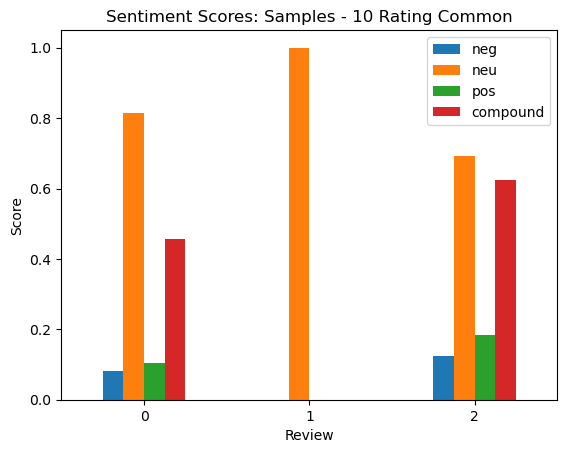

In [119]:
#generating a bar graph of the sentiment scores for each review

final_s10c_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - 10 Rating Common', xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

I see that the word "Great," which is the sole word in the second review, is neutral. Both other reviews have a positive compound score.

I will observe reviews for the 1 Common subset below.

##### One Common

In [120]:
one_common.sample(1, random_state = 4444).values.tolist()

[['Tapentadol',
  '"I found I had unusual energy and didn&#039;t feel my back pain, was able to do a lot of the manual chores involved in renovations and spring cleaning that I put off (due to pain and lack of motivation). So far no effects of longing for a dose. I take only when the pain comes back. I&#039;m waiting for the negative but so far ... it&#039;s great!"',
  10.0,
  150]]

This medication is rated 10 by its reviewer.

In [121]:
one_common.sample(1, random_state = 5555).values.tolist()

[['Acetaminophen / codeine',
  '"I use this for my pancreatitis, NASH, and inflamed spleen. I have other health issues as well. Currently this works far better than Vicodin, or Darvocet. Those two did nothing for me with the pain, this at least takes the edge off, though. At times it does make me sleepy and drowzy at work."',
  9.0,
  18]]

This medication is rated 9 by its reviewer.

In [122]:
one_common.sample(1, random_state = 6666).values.tolist()

[['Tapentadol',
  '"Nucynta has worked very well for all my aches and pain, from the most severe to those I didn&#039;t even know I had.  At first, it did make me groggy which was a problem, but I kept taking it anyway because it did take away most of my pain.  After a couple of months of use, it takes away my pain, just like it did at the beginning, but I no longer feel sleepy.  I feel energetic, happier and am able very active because I hardly feel any pain.  I highly recommend it, but you do have to give it a chance because once your body adapts to it, the adverse effects far outweigh the benefits."',
  10.0,
  120]]

This medication is rated 10 by its reviewer.

The samples from the 1 common group have a higher mean rating than the samples from the 10 common group.

I will see what differences may exist in sentiment scores.

##### Sentiment Analysis

In [123]:
sample1c = pd.concat([one_common.sample(1, random_state = 4444), one_common.sample(1, random_state = 5555),
                     one_common.sample(1, random_state = 6666)])

sample1c

,drug,review,rating,usefulcount
54588,Tapentadol,"""I found I had unusual energy and didn&#039;t ...",10.0,150
30324,Acetaminophen / codeine,"""I use this for my pancreatitis, NASH, and inf...",9.0,18
54561,Tapentadol,"""Nucynta has worked very well for all my aches...",10.0,120


In [124]:
words1c = sample1c.review.values.tolist()

words1c_df = pd.DataFrame(words1c)

words1c_df

,0
0,"""I found I had unusual energy and didn&#039;t ..."
1,"""I use this for my pancreatitis, NASH, and inf..."
2,"""Nucynta has worked very well for all my aches..."


In [125]:
scores_s1c = [sia.polarity_scores(word) for word in sample1c['review']]

scores_s1c_sentiments = pd.DataFrame(scores_s1c)

final_s1c_sentiments = pd.concat([words1c_df, scores_s1c_sentiments], axis=1)

final_s1c_sentiments

,0,neg,neu,pos,compound
0,"""I found I had unusual energy and didn&#039;t ...",0.196,0.782,0.022,-0.8394
1,"""I use this for my pancreatitis, NASH, and inf...",0.095,0.821,0.084,-0.1779
2,"""Nucynta has worked very well for all my aches...",0.191,0.641,0.168,-0.3118


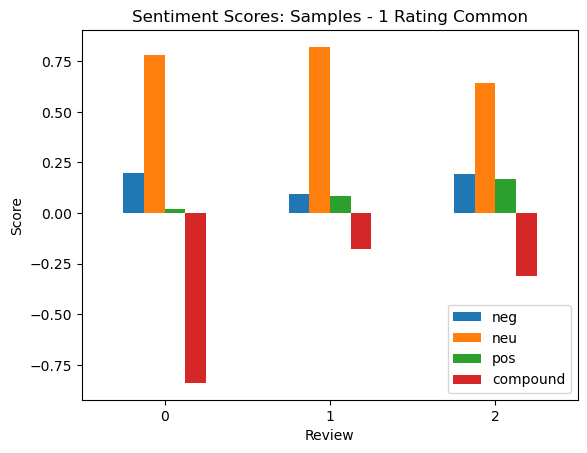

In [126]:
final_s1c_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - 1 Rating Common', 
                          xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

Although the ratings for the samples in the 1 Common grop are higher than those of the 10 Common group, the mean compound sentiment scores are lower.

It might be worth considering the implications of these findings...perhaps sentiment scores are not always the best measure of how positive/negative a review is overall.

I will keep this in mind as I move on to observe reviews for the drug with the highest average rating from the 10 Common group and the drug with the lowest average rating from the 1 Common Group.

### Creating Case Study

##### Oxycodone

With a mean rating of 8.857651, Oxycodone is the most highly-rated pain drug in the 10 common dataset.

Below, I will create and analyze a subset of reviews for Oxycodone in the management of pain.

In [127]:
oxycodone = pain.loc[pain['drug'] == 'Oxycodone']

oxycodone = pd.DataFrame(oxycodone)

In [128]:
oxycodone.head()

,drug,review,rating,usefulcount
131464,Oxycodone,"""I recently had 3 very painful surgeries withi...",9.0,2
131466,Oxycodone,"""severe lower back pain, sicatica etc. Pain m...",10.0,8
131483,Oxycodone,"""I take these occasionally for breakthrough pa...",10.0,26
131490,Oxycodone,"""My sig other was being given roxy 30s daily ...",8.0,23
131494,Oxycodone,"""I have been using 5 milligram oxycodone 30 mi...",10.0,44


In [129]:
oxycodone.shape

(281, 4)

In [130]:
oxycodone.rating.describe()

count    281.000000
mean       8.857651
std        1.701161
min        1.000000
25%        9.000000
50%        9.000000
75%       10.000000
max       10.000000
Name: rating, dtype: float64

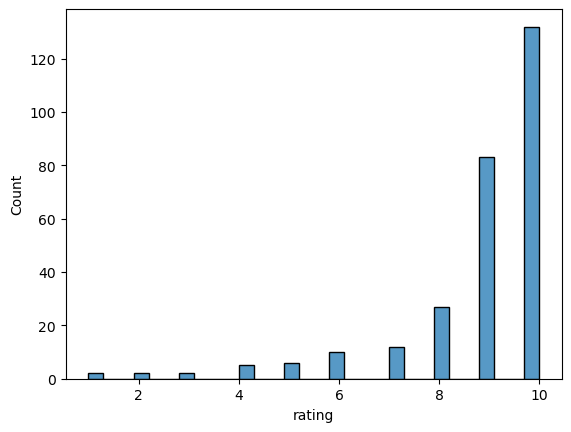

In [131]:
sns.histplot(data=oxycodone, x='rating');

In [132]:
oxycodone.rating.mode()

0    10.0
Name: rating, dtype: float64

There is a strong skew to the left, with higher ratings more common, and 10 as the mode.

In [133]:
oxycodone.usefulcount.describe()

count    281.000000
mean      45.462633
std       67.273372
min        1.000000
25%       11.000000
50%       26.000000
75%       49.000000
max      463.000000
Name: usefulcount, dtype: float64

The mean useful count for Oxycodone reviews is 45.46.

I will keep all of these values in mind as I move on to observe reviews for Acetominophin/Codeine.

##### Acetaminophen / codeine

With a mean rating of 4.94, Acetaminophen / codeine has the lowest mean rating of drugs in the 1 common subset.

I will explore further below.

In [134]:
ac = pain.loc[pain['drug'] == 'Acetaminophen / codeine']

ac = pd.DataFrame(ac)

In [135]:
ac.head()

,drug,review,rating,usefulcount
30317,Acetaminophen / codeine,"""I have very swollen lymph nodes in my neck, c...",9.0,38
30318,Acetaminophen / codeine,"""I am still in tears from my wisdom teeth popp...",1.0,39
30319,Acetaminophen / codeine,"""Little to no relief for knee pain!""",1.0,40
30320,Acetaminophen / codeine,"""I have broken bone. This helps a lot with mod...",7.0,16
30321,Acetaminophen / codeine,"""I am in severe pain. I believe I need 2 root ...",1.0,32


In [136]:
ac.shape

(94, 4)

In [137]:
ac.rating.describe()

count    94.000000
mean      4.946809
std       3.508414
min       1.000000
25%       1.000000
50%       5.000000
75%       8.000000
max      10.000000
Name: rating, dtype: float64

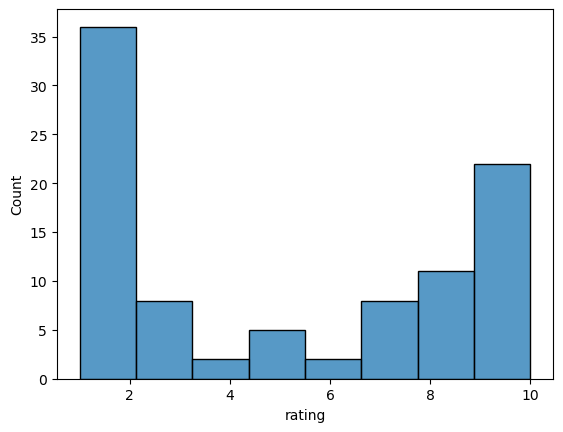

In [138]:
sns.histplot(data=ac, x='rating');

In [139]:
ac.rating.mode()

0    1.0
Name: rating, dtype: float64

While there are a significant number of reviews giving ratings of 10, the most frequent rating given is 1. This is a strong contrast to Oxycodone with its mode of 10.

Now, I will use NLP with Sentiment Analysis to discover any differences.

### Oxycodone v. Acetaminophen / codeine

Before analyzing the text contained within the reviews, I will create a new stop words filter that contains the names of the drugs being reviewed.

In [140]:
oxyacet_stop_words = text.ENGLISH_STOP_WORDS.union(['039' ,'ve', 
                                                    'oxycodone', 'acetaminophen', 'codeine', 'tylenol', 'oxycontin'])

len(oxyacet_stop_words)

325

I will now move on to use NLP.

### Bigrams

##### Oxycodone

In [141]:
#converts each title bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=oxyacet_stop_words, ngram_range=(2,2))

cv_bigrams.fit(oxycodone['review'])

oxycodone_cv_bigrams= cv_bigrams.transform(oxycodone['review'])
oxycodone_cv_bigrams= pd.DataFrame(oxycodone_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [142]:
oxycodone_cv_bigrams.shape

(281, 6251)

In [143]:
oxycodone_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

times day            37
chronic pain         35
twice day            21
breakthrough pain    21
pain medication      17
pain relief          17
quality life         16
years old            13
years ago            12
30 mg                11
severe pain          11
degenerative disc    11
disc disease         11
feel like            11
pain medicines       11
pain medicine        11
god send             10
10 years             10
pain management      10
pain years            9
dtype: int64

Some of these bigrams as descriptive, such as "breakthrough pain," "pain relief," and "god send." There are also a number of mentions of "degenerative disc." I will compare these to the bigrams I will observe for Acetominophen/Codeine below.

##### Acetaminophen / codeine

In [144]:
#converts each title bigram into a column to create a dataframe

cv_bigrams = CountVectorizer(stop_words=oxyacet_stop_words, ngram_range=(2,2))

cv_bigrams.fit(ac['review'])

ac_cv_bigrams= cv_bigrams.transform(ac['review'])
ac_cv_bigrams= pd.DataFrame(ac_cv_bigrams.todense(), columns = cv_bigrams.get_feature_names_out())

In [145]:
ac_cv_bigrams.shape

(94, 2017)

In [146]:
ac_cv_bigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

pain relief        8
wisdom teeth       7
severe pain        6
root canal         6
wisdom tooth       5
pain makes         4
helps good         4
went er            4
good deal          4
moderate pain      3
pain management    3
hip pain           3
say pain           3
does work          3
didn make          3
helps lot          3
30 minutes         3
deal pain          3
don know           3
relief pain        3
dtype: int64

The bigrams here are different from those oberved for Oxycodone. Some of these reference specific uses, such as "wisdom teeth," and "root canal." Others mention tylenol specifically.

This highlights the fact that the two drugs may be used in different scenarios. I will keep this in mind when I move into modeling, further discussed in the next notebook.

For now, I will move on to observe trigrams.

### Trigrams

##### Oxycodone

In [147]:
cv_trigrams = CountVectorizer(stop_words=oxyacet_stop_words, ngram_range=(3,3))

cv_trigrams.fit(oxycodone['review'])

oxycodone_cv_trigrams= cv_trigrams.transform(oxycodone['review'])
oxycodone_cv_trigrams= pd.DataFrame(oxycodone_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [148]:
oxycodone_cv_trigrams.shape

(281, 7005)

In [149]:
oxycodone_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

degenerative disc disease      10
pain management doctor          6
quot high quot                  4
mg times day                    4
times day pain                  4
suffering severe testicular     3
took away pain                  3
taking 30 mg                    3
60mg times day                  3
percocet 10 325                 3
tried pain medication           3
40mg times day                  3
times day methadone             3
30mg times day                  3
30mg immediate release          3
times day taking                3
given quality life              3
20 years old                    3
times day 10                    3
great pain relief               3
dtype: int64

##### Acetaminophen / codeine

In [150]:

cv_trigrams = CountVectorizer(stop_words=oxyacet_stop_words, ngram_range=(3,3))

cv_trigrams.fit(ac['review'])

ac_cv_trigrams= cv_trigrams.transform(ac['review'])
ac_cv_trigrams= pd.DataFrame(ac_cv_trigrams.todense(), columns = cv_trigrams.get_feature_names_out())

In [151]:
ac_cv_trigrams.shape

(94, 2061)

In [152]:
ac_cv_trigrams.sum().sort_values(ascending = False).head(20) #shows 20 most bigrams in reviews

helps good deal                    4
wisdom teeth pulled                2
prescribed penicillin ibuprofen    2
deal pain carisoprodol             2
lower hip pain                     2
good deal pain                     2
30 minutes later                   2
pain carisoprodol helps            2
wisdom tooth removed               2
carisoprodol helps good            2
high pain tolerance                2
wisdom teeth taken                 2
plus xanax help                    1
prefer number pain                 1
pre op rotator                     1
posterior repairs bladder          1
post surgury experiencing          1
post surgical pain                 1
pissed pain don                    1
post op normal                     1
dtype: int64

Both sets of reviews mention other pain revlievers. Additionally, the most frequent trigrams differ between the two drugs, but not necessarily in a way that shows one being perceived as more effective than the other.

I will continue with Sentiment Analysis below.

### Sentiment Analysis

##### Oxycodone

In [153]:
scores_oxy = [sia.polarity_scores(word) for word in oxycodone['review']]

scores_oxy_sentiments = pd.DataFrame(scores_oxy)

In [154]:
scores_oxy_sentiments.shape

(281, 4)

In [155]:
scores_oxy_sentiments.describe()

,neg,neu,pos,compound
count,281.000000,281.000000,281.000000,281.000000
mean,0.140075,0.749520,0.110441,-0.213418
std,0.098920,0.136819,0.107898,0.618745
min,0.000000,0.160000,0.000000,-0.989700
25%,0.079000,0.689000,0.044000,-0.807000
50%,0.135000,0.769000,0.088000,-0.338200
75%,0.189000,0.830000,0.148000,0.340000
max,0.767000,1.000000,0.694000,0.947500


Mean Sentiment Scores are:
    
Negative: 0.140075
Neutral: 0.749520
Positive: 0.110441
Compound: -0.213418

I will compare these scores to the ones the reviews for Acetaminophen / codeine receive below.

##### Acetaminophen / codeine

In [156]:
scores_ac = [sia.polarity_scores(word) for word in ac['review']]

scores_ac_sentiments = pd.DataFrame(scores_ac)

In [157]:
scores_ac_sentiments.shape

(94, 4)

In [158]:
scores_ac_sentiments.describe()

,neg,neu,pos,compound
count,94.000000,94.000000,94.000000,94.000000
mean,0.165372,0.732170,0.102457,-0.349932
std,0.099197,0.126897,0.105748,0.548227
min,0.000000,0.238000,0.000000,-0.987700
25%,0.110500,0.673500,0.041000,-0.813550
50%,0.154500,0.740000,0.083000,-0.510600
75%,0.207000,0.818000,0.141750,-0.068250
max,0.470000,1.000000,0.762000,0.865900


Mean Sentiment Scores are:

Negative: 0.165372
Neutral: 0.732170
Positive: 0.102457
Compound: -0.349932

The reviews for Acetaminophen/Codeine have a lower average compound score.

I will see what the sample reviews of each drug reveal below.

### Samples

#### Oxycodone

In [159]:
oxycodone.sample(1, random_state = 1).values.tolist()

[['Oxycodone',
  '"I&#039;ve taken many different opiates over the years for chipped bone spurs in neck and multiple abnormalities in my lower back. This medicine is a miracle for me. I rated it a &quot;10&quot; because the last 6 months i&#039;ve been prescribed it,&quot;i feel no pain at all&quot;."',
  10.0,
  9]]

This person writes, "This medicine is a miracle for me," and rates it a 10.

In [160]:
oxycodone.sample(1, random_state = 2).values.tolist()

[['Oxycodone',
  '"I am a 47 year old male who has taken this drug for 10 years. (300 mg per day everyday.)  Yes it will ease pain, but normally 2 to 3 years you have to increase it. I was medically dependent within months.  In late fall 09, the medicines just lost their effect by at least 50%.  So I was faced with a 50% increase in medicines.  I said NO!  So I tried a medical detox place to start.  After 90 hours there, they said you have done great we are sending you home.  I was so proud till 4a.m. the next day. I threw up 90 times in the next 60 hours.  I lost 34lbs. in 8 days and had severe withdrawal symptoms for 2 more weeks. It has been 30 days since I started this and I will never put that poison in my body. "',
  5.0,
  77]]

This person writes, "Yes it will ease pain, but normally 2 to 3 years you have to increase it. I was medically dependent within months," and then goes on to describe difficulties when detoxing, rating the medication a 5.

In [161]:
oxycodone.sample(1, random_state = 3).values.tolist()

[['Oxycodone',
  '"I have degenerative disc disease and arthritis - dads got RA, I probably do to. It is very effective against chronic pain. I can play with my kids and surf. There is no reason to treat this very effective medicine as an outcast. Sure, it can be misused, but for real chronic pain sufferers like myself, its nothing short of a God send. Take as little as you can and still maintain effectiveness."',
  9.0,
  16]]

This person writes, "It is very effective against chronic pain. I can play with my kids and surf. There is no reason to treat this very effective medicine as an outcast," and rates it a 9.

##### Sentiment Analysis

In [162]:
sampleoxy = pd.concat([oxycodone.sample(1, random_state = 1), oxycodone.sample(1, random_state = 2),
                     oxycodone.sample(1, random_state = 3)])
                      
sampleoxy

,drug,review,rating,usefulcount
131725,Oxycodone,"""I&#039;ve taken many different opiates over t...",10.0,9
131784,Oxycodone,"""I am a 47 year old male who has taken this dr...",5.0,77
131900,Oxycodone,"""I have degenerative disc disease and arthriti...",9.0,16


In [163]:
wordsoxy = sampleoxy.review.values.tolist()

wordsoxy_df = pd.DataFrame(wordsoxy)

wordsoxy_df

,0
0,"""I&#039;ve taken many different opiates over t..."
1,"""I am a 47 year old male who has taken this dr..."
2,"""I have degenerative disc disease and arthriti..."


In [164]:
scores_oxy = [sia.polarity_scores(word) for word in sampleoxy['review']]

scores_oxy_sentiments = pd.DataFrame(scores_oxy)

final_oxy_sentiments = pd.concat([wordsoxy_df, scores_oxy_sentiments], axis=1)

final_oxy_sentiments

,0,neg,neu,pos,compound
0,"""I&#039;ve taken many different opiates over t...",0.152,0.772,0.075,-0.4404
1,"""I am a 47 year old male who has taken this dr...",0.097,0.740,0.163,0.8886
2,"""I have degenerative disc disease and arthriti...",0.175,0.675,0.150,-0.6343


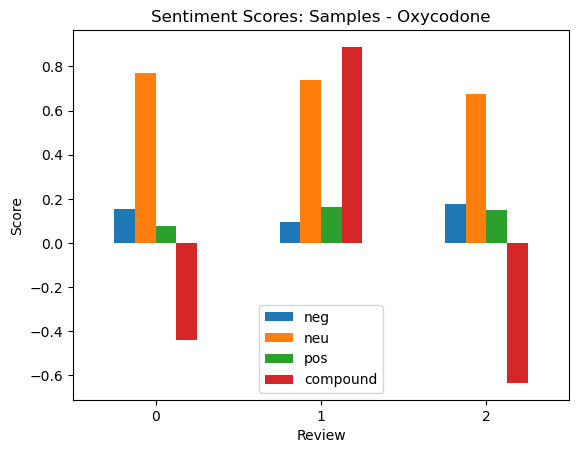

In [165]:
final_oxy_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - Oxycodone', 
                          xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

#### Acetaminophen / codeine

In [166]:
ac.sample(1, random_state = 1001).values.tolist()

[['Acetaminophen / codeine',
  '"I am currently taking this medication for moderate pain reduction. I hurt my wrist by falling on concrete stairs. It does reduce the pain and works very well. The only downside is stomach upset, nausea, and extreme sleepiness. I do not have any kind of narcotic tolerance. This medicine is for minor to moderate relief of pain, and should be used as such. This medicine in my book scores a 8 out of 10 points for managing moderate pain. Highly recommend."',
  8.0,
  11]]

This person writes, "It does reduce the pain and works very well. The only downside is stomach upset, nausea, and extreme sleepiness. I do not have any kind of narcotic tolerance," and rates the medication an 8.

In [167]:
ac.sample(1, random_state = 1011).values.tolist()

[['Acetaminophen / codeine',
  '"I have &quot;loose shoulders&quot; and my doctor perscribed this to me. I am 14 and it feels kind of weird as it is my first pain medication other that ibuprofen. It works rather quickly and subsides some pain but not all. Also makes me drowsy, so I only take it at night."',
  7.0,
  25]]

This person writes, "It works rather quickly and subsides some pain but not all. Also makes me drowsy, so I only take it at night," and rates the medication a 7.

In [168]:
ac.sample(1, random_state = 1101).values.tolist()

[['Acetaminophen / codeine',
  '"I had oral surgery and my doctor prescribed me this and it didn&#039;t touch the pain at all. "',
  5.0,
  39]]

This person writes that the medication "didn&#039;t touch the pain at all," and rates it a 5.

##### Sentiment Analysis

In [169]:
#creating a dataframe of the sample reviews

sampleac = pd.concat([ac.sample(1, random_state = 1001), ac.sample(1, random_state = 1011),
                     ac.sample(1, random_state = 1101)])
                      
sampleac

,drug,review,rating,usefulcount
30351,Acetaminophen / codeine,"""I am currently taking this medication for mod...",8.0,11
30373,Acetaminophen / codeine,"""I have &quot;loose shoulders&quot; and my doc...",7.0,25
30334,Acetaminophen / codeine,"""I had oral surgery and my doctor prescribed m...",5.0,39


In [170]:
#creating a dataframe of only the reviews

wordsac = sampleac.review.values.tolist()

wordsac_df = pd.DataFrame(wordsac)

wordsac_df

,0
0,"""I am currently taking this medication for mod..."
1,"""I have &quot;loose shoulders&quot; and my doc..."
2,"""I had oral surgery and my doctor prescribed m..."


In [171]:
#creating a new dataframe by concatenating the review &sentiment score dataframes

scores_ac = [sia.polarity_scores(word) for word in sampleac['review']]

scores_ac_sentiments = pd.DataFrame(scores_ac)

final_ac_sentiments = pd.concat([wordsac_df, scores_ac_sentiments], axis=1)

final_ac_sentiments

,0,neg,neu,pos,compound
0,"""I am currently taking this medication for mod...",0.236,0.684,0.08,-0.9338
1,"""I have &quot;loose shoulders&quot; and my doc...",0.110,0.890,0.00,-0.5854
2,"""I had oral surgery and my doctor prescribed m...",0.163,0.837,0.00,-0.5106


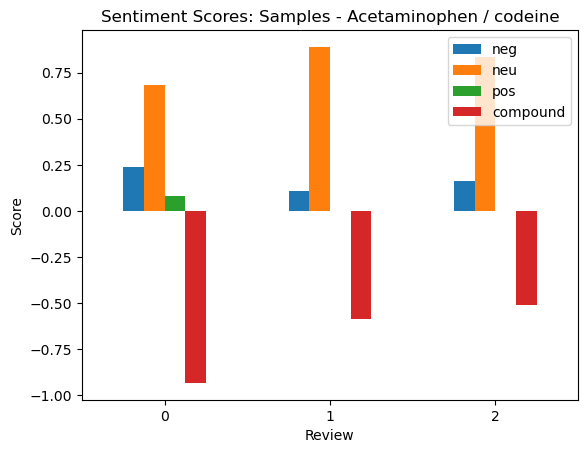

In [172]:
#creating a bargraph of sentiment scores below

final_ac_sentiments.plot(kind='bar', title='Sentiment Scores: Samples - Acetaminophen / codeine', 
                         xlabel='Review', ylabel='Score');

plt.xticks(rotation = 0);

All sentiment scores here are negative.

Overall, it seems that the two drugs do differ in terms of most frequent bigrams and trigrams are contained within the reviews. Additionally, the reviews for Acetaminophen/codeine have a lower mean compound sentiment score. It was earlier determined that Oxycodone has a much higher mean rating (8.85) than Acetaminophen/codeine (4.94.)

However, I could also see that there are differences in terms of what the drugs are used for. As described [here](https://www.mayoclinic.org/drugs-supplements/oxycodone-oral-route/description/drg-20074193), Oxycodone is prescribed for chronic, serious pain that is strong enough to necessitate treatment with an opiate. Meanwhile, Acetamenophin/codeine is prescribed for mild to moderate pain, as described [here](https://www.mayoclinic.org/drugs-supplements/acetaminophen-and-codeine-oral-route/description/drg-20074117).

When I later create a model to distinguish between two pain relievers, I will likely replace Acetamenophin/codeine with a different opiate that could be more justly compared to Oxycodone. Tramadol is a likely candidate, as it was a part of the 1 Common group, with a mean rating lower than Oxycodone's, but is similarly an opiate, and is used for moderate to moderately severe pain.

I will explore this in the next notebook, but first I would like to observe mentions of side effects within the reviews.

## Side Effects

It may be the case that medical providers, insurers, and/or patients would be interested to know which of the medications tend to bring about certain side effects. 

The complication is that many times, reviews will mention side effects that people are NOT experiencing (i.e. "this works great, and is the only pain medication that doesn't give me nausea!") 

To counter for this fact, I will observe for mentions of side effects that occur in reviews in which the drugs are given low ratings (less than 5.) I hypothesize that this will allow me to observe reviews in which the side effects ARE occuring, because the patient has a negative perspective of the medication.

I will begin by preparing this subset below.

##### Creating subset

In [173]:
low = pain[pain['rating']<5]

low.head()

,drug,review,rating,usefulcount
1944,Belbuca,"""I was on Fentynal patches for year and a hal...",1.0,14
2556,Darvocet A500,"""I have Anklosing spondylitis, arthritis in ma...",1.0,19
2890,Codeine,"""Had Panadeine Forte for a tooth abscess pain....",1.0,14
2892,Codeine,"""My dentist prescribed it to me to treat a too...",1.0,19
2906,Codeine,"""I had an external hemorrhoids surgery and cod...",1.0,2


In [174]:
low.rating.unique()

array([1., 3., 2., 4.])

In [175]:
low.shape

(1041, 4)

We can now make observations about this group.

In [176]:
low.drug.value_counts()

Tramadol                   102
Tapentadol                  64
Gabapentin                  55
Acetaminophen / codeine     46
Nucynta                     42
                          ... 
Duramorph                    1
Dolobid                      1
Trolamine salicylate         1
Naprosyn                     1
Belbuca                      1
Name: drug, Length: 119, dtype: int64

In [177]:
low.rating.mean()

1.8309317963496639

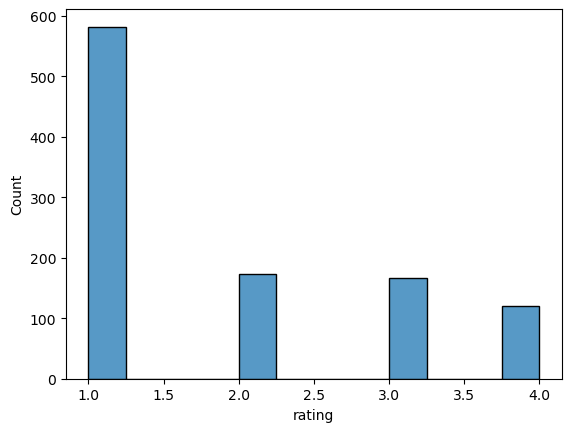

In [178]:
sns.histplot(data=low, x='rating');

This subset is ready, and contains 1041 reviews to analyze. I will first observe mentions of "tolerance."

##### Tolerance

In [179]:
tolerance = low[low['review'].str.contains('tolerance')]

tolerance

,drug,review,rating,usefulcount
14347,Nucynta,"""Was put on nucynta 100 mg every six hours for...",1.0,26
23804,Tramadol,"""This pain reliever is not the best, but it he...",1.0,26
30322,Acetaminophen / codeine,"""I have to take this following surgery to remo...",2.0,5
30346,Acetaminophen / codeine,"""My wisdom tooth got infected(pericoronitis) a...",1.0,14
30354,Acetaminophen / codeine,"""I was diagnosed with a missed miscarriage las...",1.0,11
30377,Acetaminophen / codeine,"""I need to get a wisdom tooth removed and have...",3.0,3
37370,Tylenol with Codeine #3,"""My wisdom tooth got infected(pericoronitis) a...",1.0,14
40262,Acetaminophen / hydrocodone,"""Built up a tolerance to it very quickly and m...",4.0,10
42167,Ziconotide,"""Once it was introduced into my pump my legs f...",1.0,1
60928,Prialt,"""Once it was introduced into my pump my legs f...",1.0,1


In [180]:
#creating a dataframe for later use

tolerance = pd.DataFrame(tolerance)

tolerance['side_effect'] = 'tolerance'

In [181]:
tolerance.head()

,drug,review,rating,usefulcount,side_effect
14347,Nucynta,"""Was put on nucynta 100 mg every six hours for...",1.0,26,tolerance
23804,Tramadol,"""This pain reliever is not the best, but it he...",1.0,26,tolerance
30322,Acetaminophen / codeine,"""I have to take this following surgery to remo...",2.0,5,tolerance
30346,Acetaminophen / codeine,"""My wisdom tooth got infected(pericoronitis) a...",1.0,14,tolerance
30354,Acetaminophen / codeine,"""I was diagnosed with a missed miscarriage las...",1.0,11,tolerance


In [182]:
tolerance.shape

(14, 5)

In [183]:
tolerance.rating.mean()

1.8571428571428572

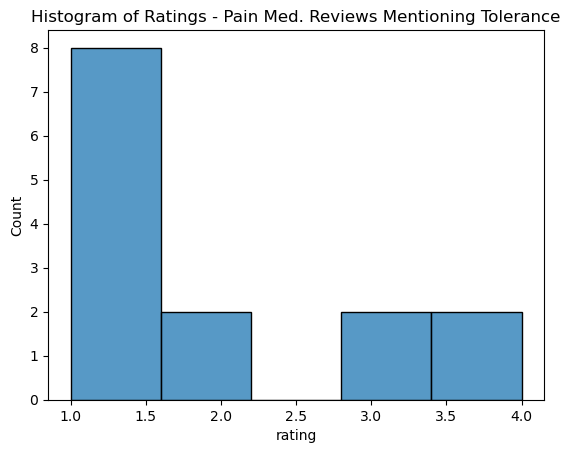

In [184]:
sns.histplot(data= tolerance, x='rating').set(
    title = 'Histogram of Ratings - Pain Med. Reviews Mentioning Tolerance');

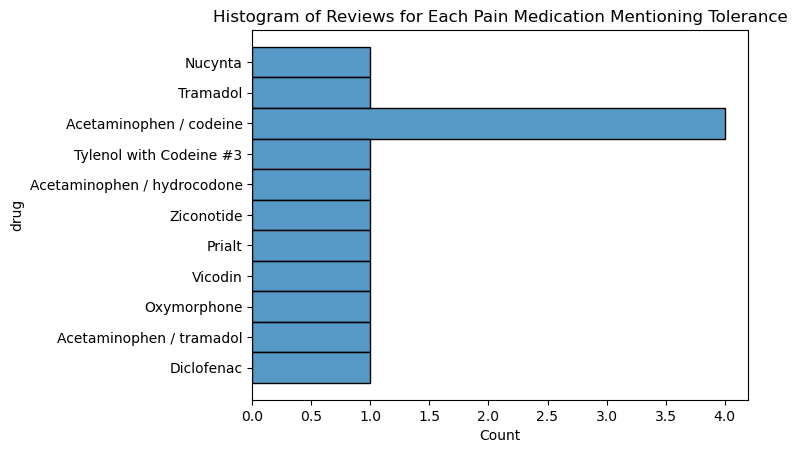

In [185]:
sns.histplot(data= tolerance, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Tolerance');

In [186]:
tolerance.sample(5, random_state = 6789).values.tolist()

[['Ziconotide',
  '"Once it was introduced into my pump my legs felt as though they were on fire this was corrected with bynedryel. The following effects were an intolerance to light that caused migraines also the lack of bowel control and the loss of hearing in my right ear and visual problems that left me unable to drive.I had to go to my doctor and insist that the prialt be removed. He resisted but I prevailed. I have never been that sick with multiple illnesses in my life.  I have had 3 spinal bone fusions and 2 thumb reconstructions with right and left shoulder operations also a right knee operation and countless spinal injections and on and on. Because of my doctors reluctance to extract the prialt. I called the manufacturer of prialt who stopped it instantly."',
  1.0,
  1,
  'tolerance'],
 ['Oxymorphone',
  '"I have spinal stenosis, DDD, bone spurs, ruptured discs, double laminectomy at L5-S1, L3-L4 in 2013. I&#039;ve been on oxycodone for over 4 years. That worked great but I 

Some, but not all, of these reviews reference problems with tolerance to the specific medication being reviewed, most give vivid descriptions of side effects that are being experienced.

This subset could be useful to review if looking for patient experiences of negative side effects.

I will move on to observe mentions of "withdrawal."

##### "Withdrawal"

In [187]:
withdrawal = low[low['review'].str.contains('withdrawal')]

withdrawal.head()

,drug,review,rating,usefulcount
4097,Opana,"""I&#039;ve been on oxymorphone for 10 years. M...",1.0,22
14320,Nucynta,"""After 10 years of a combination of treatments...",1.0,29
14327,Nucynta,"""I was prescribed this medication because I&#0...",1.0,47
14335,Nucynta,"""I was switched to nucynta 75mg three daily fr...",1.0,5
14338,Nucynta,"""was on 15mg opanaer 2 x daily down from 2 x 3...",1.0,5


In [188]:
#creating a dataframe for later use & displaying top 5 row

withdrawal = pd.DataFrame(withdrawal)

withdrawal['side_effect'] = 'withdrawal'

withdrawal.head()

,drug,review,rating,usefulcount,side_effect
4097,Opana,"""I&#039;ve been on oxymorphone for 10 years. M...",1.0,22,withdrawal
14320,Nucynta,"""After 10 years of a combination of treatments...",1.0,29,withdrawal
14327,Nucynta,"""I was prescribed this medication because I&#0...",1.0,47,withdrawal
14335,Nucynta,"""I was switched to nucynta 75mg three daily fr...",1.0,5,withdrawal
14338,Nucynta,"""was on 15mg opanaer 2 x daily down from 2 x 3...",1.0,5,withdrawal


In [189]:
withdrawal.shape

(45, 5)

In [190]:
withdrawal.rating.mean()

1.6222222222222222

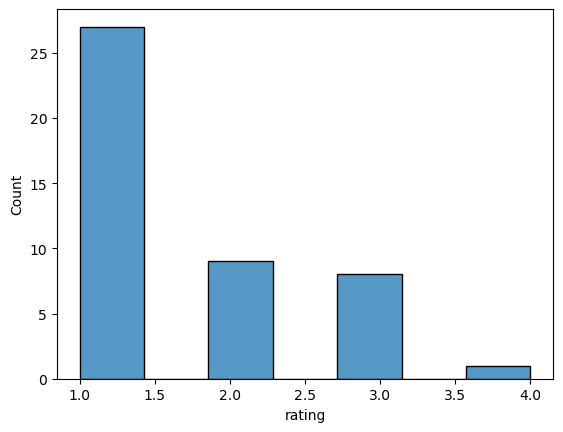

In [191]:
sns.histplot(data = withdrawal, x= 'rating');

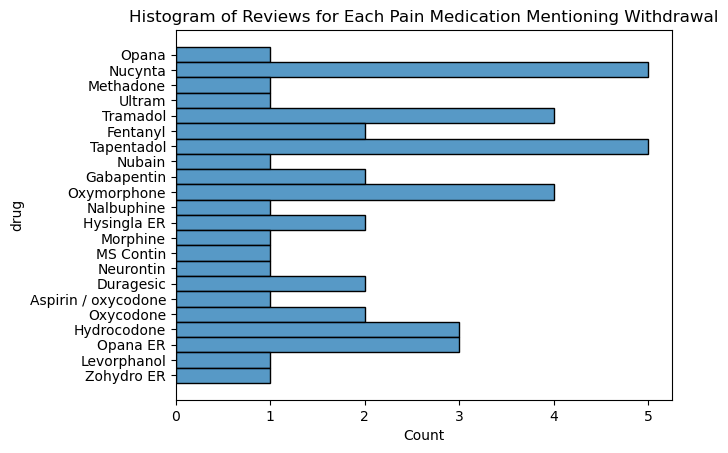

In [192]:
sns.histplot(data= withdrawal, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Withdrawal');

In [193]:
withdrawal.review.sample(5, random_state = 6789).values.tolist()

['"I was prescribed this medicine for moderate pain after surgery. My incisions bothered me, and I took 4 pills a day for the first 3 days, then usually 2 a day. However, the side effects: nausea, palpitations, dizziness, drowsiness AND sleeplessness, constipation and mental vagueness were really too unpleasant to be rid of minor pain, so after a week I stopped taking it. It is annoying that after stopping it, I suffered nausea, palpitations, and weakness/drowsiness after large meals--possibly due to withdrawal."',
 '"This medication isn&#039;t that effective compared to taking Norco since Norco releases most of its metabolytes within an hour immediately causing pain relief. Switching over to Hysingla has not only cost me way more money per month but also has caused me to have severe withdrawals and pain to due it&#039;s very slow time release of the medication. I take 20 mg of Norco at a time tid and I&#039;m on the Hysingla 30mg. So with that being said, my body is used to 20mg of mo

These reviews do seem to discuss dependency issues.

This information might be useful for those researching issues with withdrawal from pain medications.

Next, I will observe mentions of nausea.

##### Nausea

In [194]:
nausea = low[low['review'].str.contains('nausea')]

nausea

,drug,review,rating,usefulcount
12780,Embeda,"""I was taking Opana ER 20 and was switched by ...",1.0,36
12823,Voltaren,"""The side effects are brutal. Stomach aches, n...",2.0,29
14347,Nucynta,"""Was put on nucynta 100 mg every six hours for...",1.0,26
14360,Nucynta,"""Lots of nausea""",3.0,34
14454,Nucynta,"""My doctor wanted to try me on Nucynta for my ...",1.0,32
...,...,...,...,...
134831,Dilaudid,"""I was given a dose of delaudid through IV for...",2.0,22
141164,Fentanyl Transdermal System,"""This medication is supposed to be continual p...",4.0,65
142402,Toradol,"""I end up in the ER at least twice a month wit...",1.0,18
158554,Butrans,"""I&#039;ve been using this patch for 2 and a h...",2.0,43


In [195]:
#turns subset into a dataframe for later use & displays top 5 rows

nausea = pd.DataFrame(nausea)

nausea['side_effect'] = 'nausea'

nausea.head()

,drug,review,rating,usefulcount,side_effect
12780,Embeda,"""I was taking Opana ER 20 and was switched by ...",1.0,36,nausea
12823,Voltaren,"""The side effects are brutal. Stomach aches, n...",2.0,29,nausea
14347,Nucynta,"""Was put on nucynta 100 mg every six hours for...",1.0,26,nausea
14360,Nucynta,"""Lots of nausea""",3.0,34,nausea
14454,Nucynta,"""My doctor wanted to try me on Nucynta for my ...",1.0,32,nausea


In [196]:
nausea.rating.mean()

1.8526315789473684

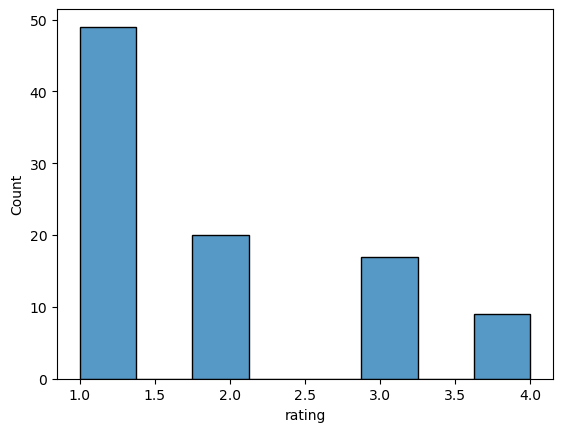

In [197]:
sns.histplot(data=nausea, x='rating');

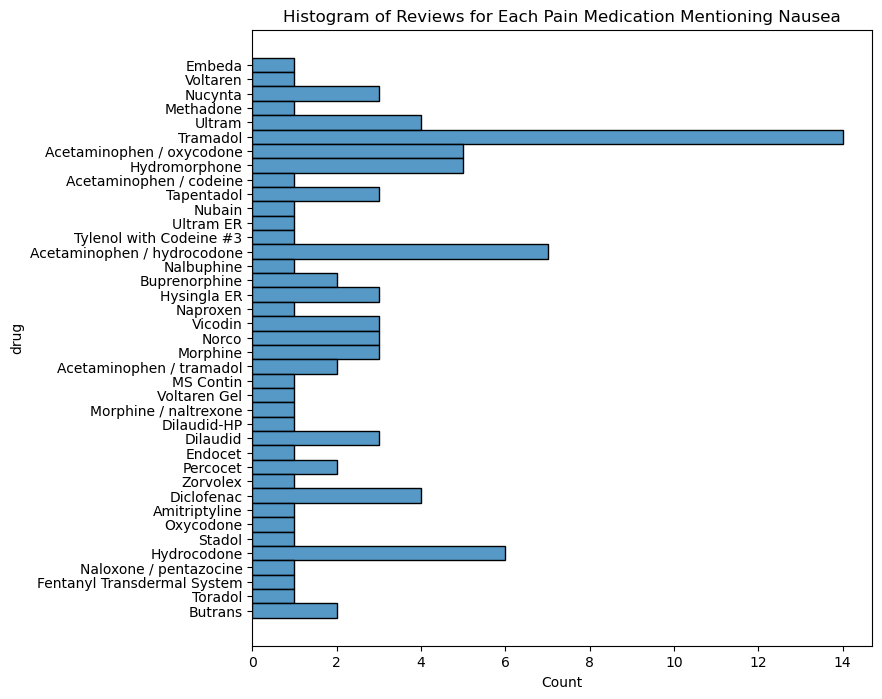

In [198]:
fig, ax = plt.subplots(figsize = (8,8))

sns.histplot(data= nausea, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Nausea');

In [199]:
nausea.sample(5, random_state = 6789).values.tolist()

[['Stadol',
  '"I have migraines really bad, my neurologist prescirbed Stadol as a last resort medication.  So far it has not worked.  Just made me nauseated and gave me a head rush.  It&#039;s very discouraging to read the comments about ER&#039;s thinking migraine sufferers are drug seeking people.  It&#039;s sad that we get no attention or help.  I would rather suffer than go to the ER and be put in a group that I&#039;m not in.  Good luck to all of us :)"',
  3.0,
  19,
  'nausea'],
 ['Tramadol',
  '"Tramadol made me so queasy that I couldn&#039;t sit up or walk without feeling nausea. Didn&#039;t touch the head pain."',
  1.0,
  5,
  'nausea'],
 ['Butrans',
  '"I have been on Butrans patch for about 6 months. Started on 5mg, then 10mg after a few months, and then 20mg. I had several side effects although it did relieve my pain. Just the past two days I had to go off of the patch because my side effects were very worse with being on the 20mg. The side effects I have experience sinc

These reviews give vivid description of negative side effects of the drugs, including nausea. This could be useful information for those seeking to learn more about patient experiences of nausea, and the medications that engender them.

Below, I will observe mentions of hallucination.

##### Hallucinations

In [200]:
hallucinations = low[low['review'].str.contains('hallucinat')]

hallucinations

,drug,review,rating,usefulcount
14327,Nucynta,"""I was prescribed this medication because I&#0...",1.0,47
14329,Nucynta,"""I got nucynta after I had surgery on my hand....",1.0,49
14392,Nucynta,"""I was put on 100mg of Nucynta ER for facial n...",3.0,29
14397,Nucynta,"""Was prescribed Nucynta for back pain after in...",3.0,16
16255,Methadone,"""I have Lupus, RA two other types of arthritis...",1.0,22
18729,Ultram,"""Personally the medicine worked well for chron...",3.0,42
30192,Hydromorphone,"""My father-in-law was given this medicine afte...",1.0,17
32805,Talwin,"""Scary medicine given for migraine, sent home....",1.0,4
32963,Tapentadol,"""I was prescribed this medication because I&#0...",1.0,47
32968,Tapentadol,"""I got nucynta after I had surgery on my hand....",1.0,49


In [201]:
#turns subset into a dataframe for later use & displays top 5 rows

hallucinations = pd.DataFrame(hallucinations)

hallucinations['side_effect'] = 'hallucinations'

hallucinations.head()

,drug,review,rating,usefulcount,side_effect
14327,Nucynta,"""I was prescribed this medication because I&#0...",1.0,47,hallucinations
14329,Nucynta,"""I got nucynta after I had surgery on my hand....",1.0,49,hallucinations
14392,Nucynta,"""I was put on 100mg of Nucynta ER for facial n...",3.0,29,hallucinations
14397,Nucynta,"""Was prescribed Nucynta for back pain after in...",3.0,16,hallucinations
16255,Methadone,"""I have Lupus, RA two other types of arthritis...",1.0,22,hallucinations


In [202]:
hallucinations.shape

(21, 5)

In [203]:
hallucinations.rating.mean()

2.142857142857143

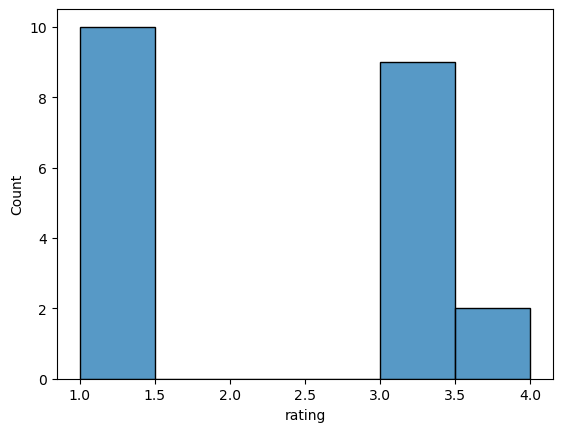

In [204]:
sns.histplot(data= hallucinations, x='rating');

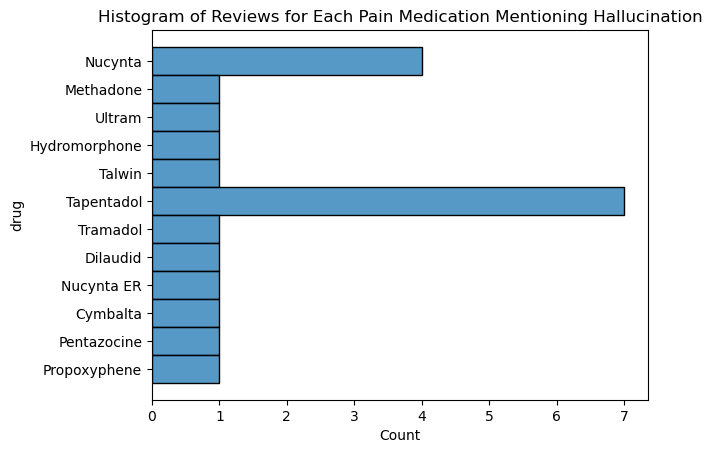

In [205]:
sns.histplot(data= hallucinations, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Hallucination');

In [206]:
hallucinations.sample(5, random_state = 6789).values.tolist()

[['Nucynta',
  '"Was prescribed Nucynta for back pain after informing the doctor of my weird reactions to various medications.  The first 100mg dose I took threw me into a near panic attack and caused some crazy depersonalization and audible hallucinations. I ended up sleeping for nearly two days after that dose.\r\n\r\n"',
  3.0,
  16,
  'hallucinations'],
 ['Tramadol',
  '"Personally the medicine worked well for chronic pleurisy pain (bad stabbing sensation in side with flu or pneumonia) but I had horrible side effects. Dazed constantly, hallucinations, cold sweats, nausea."',
  3.0,
  42,
  'hallucinations'],
 ['Tapentadol',
  '"I was prescribed this medication because I&#039;m allergic to some of the more common pain killers. I took it a total of 2 weeks, daily as prescribed.  I had horrible hallucinations  became severely depressed, had insomnia and I felt like every ounce of joy was sucked out of my body. I had the strangest experiences with this medication. I felt like I left my

Three out of five of the sample reviews are of Tapentadol or its brand name Nucynta.

I will move on to observe an even more serious side effect, which is suicidality.

##### Suicidal

In [207]:
suicidal = low[low['review'].str.contains('suicid')]

suicidal

,drug,review,rating,usefulcount
18703,Ultram,"""I have taken ultram for years on and off. I H...",1.0,64
34761,Gabapentin,"""Prescribed on Oct 5, threw it away October 25...",1.0,65
35095,Gabapentin,"""I was given this medicine in hospital to help...",1.0,130
39300,Elavil,"""I was prescribed this after a severe TBI and ...",1.0,94
50218,Tramadol,"""I have taken ultram for years on and off. I H...",1.0,64
67266,Neurontin,"""I was given this medicine in hospital to help...",1.0,130
78139,Gabapentin,"""I took 300 mg three times a day after months ...",3.0,21
105252,OxyContin,"""Five years ago, I was close to suicidal with ...",3.0,79
131716,Oxycodone,"""Five years ago, I was close to suicidal with ...",3.0,79
142181,Acetaminophen / propoxyphene,"""I was taking it for my cramps after having my...",2.0,15


In [208]:
#turns subset into a dataframe for later use & displays top 5 rows

suicidal = pd.DataFrame(suicidal)

suicidal['side_effect'] = 'suicidal'

suicidal.head()

,drug,review,rating,usefulcount,side_effect
18703,Ultram,"""I have taken ultram for years on and off. I H...",1.0,64,suicidal
34761,Gabapentin,"""Prescribed on Oct 5, threw it away October 25...",1.0,65,suicidal
35095,Gabapentin,"""I was given this medicine in hospital to help...",1.0,130,suicidal
39300,Elavil,"""I was prescribed this after a severe TBI and ...",1.0,94,suicidal
50218,Tramadol,"""I have taken ultram for years on and off. I H...",1.0,64,suicidal


In [209]:
suicidal.shape

(10, 5)

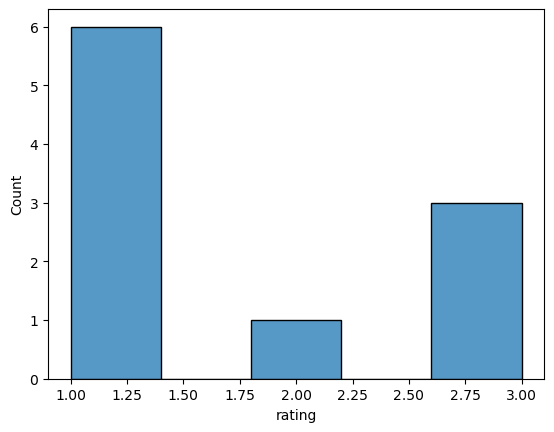

In [210]:
sns.histplot(data= suicidal, x='rating');

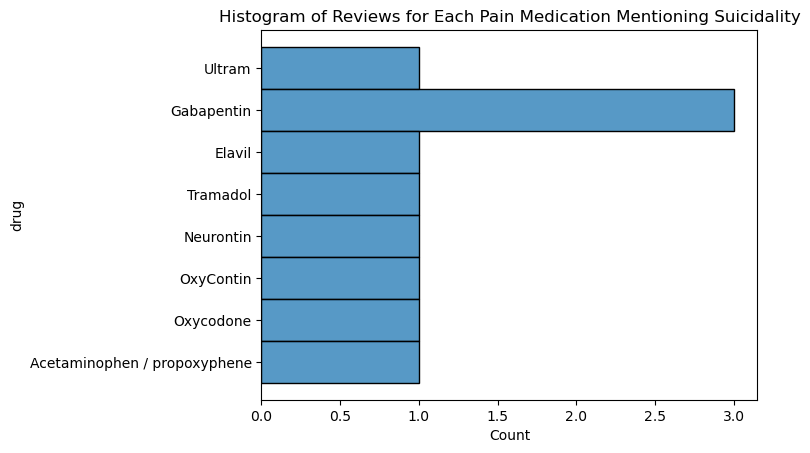

In [211]:
sns.histplot(data= suicidal, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Suicidality');

In [212]:
suicidal.sample(5, random_state = 6789).values.tolist() #displaying sample reviews

[['Elavil',
  '"I was prescribed this after a severe TBI and broken neck, it was suppose to help my headaches. After about a week it turned me into a rapid cycling bipolar suicidal freak, one second driving singing happy, next second I was trying to swerve in front of a semi."',
  1.0,
  94,
  'suicidal'],
 ['Oxycodone',
  '"Five years ago, I was close to suicidal with pain and found a superb pain management doctor.at the Beth Israel Pain &amp; Palliative Care Unit in NYC. I HIGHLY recommend them. Recently, I began to feel pain again of the acute variety (am always in some chronic pain), Said to my husband, &quot;it is as if this drug is not working at all&quot;. Went today for my regular two month check-up and told my doctor. He nodded and told me that MANY of his patients no longer get relief with Oxycontin as the new formula (meant to keep abusers from crushing it) does not work well in ER form. I had not had to use more than the same dose for 5 years, and was in relative comfort, g

Two of the reviews mention suicidality in conjunction with the reveiwed medication and Bipolar disorder, one review mentions suicidality in conjunction with a history of depression. Two seem to reference prior suicidality in reference to prior level of pain.

*One should not conclude that the references to suicidality, then, are a result of the pain medication being reviewed. It would be better to read the reviews in depth to determine, especially since there are only 10 of them.*

Next, I will explore a different side effect that, while less serious, can be very uncomfortable.

##### Constipation

In [213]:
constipation = low[low['review'].str.contains('constipat')]

constipation

,drug,review,rating,usefulcount
12779,Embeda,"""As the last reviewer said I have had increase...",1.0,29
12780,Embeda,"""I was taking Opana ER 20 and was switched by ...",1.0,36
16283,Methadone,"""Methadone was wonderful to relieve pain after...",3.0,17
18759,Ultram,"""I was prescribed this medicine for moderate p...",3.0,26
23756,Tramadol,"""This is an exceptional drug for pain relief b...",3.0,23
28372,Acetaminophen / oxycodone,"""My doc prescribed this for after having colit...",1.0,9
28430,Acetaminophen / oxycodone,"""Prescribed this after impacted wisdom teeth e...",2.0,15
39796,Oxymorphone,"""I&#039;ve been taking generic Opana (Oxymorph...",2.0,4
40294,Acetaminophen / hydrocodone,"""Prescribed when I had all 4 wisdom teeth remo...",3.0,4
48335,Buprenorphine,"""I&#039;ve been using this patch for 2 and a h...",2.0,43


In [214]:
#turns subset into a dataframe for later use & displays top 5 rows

constipation = pd.DataFrame(constipation)

constipation['side_effect'] = 'constipation'

constipation.head()

,drug,review,rating,usefulcount,side_effect
12779,Embeda,"""As the last reviewer said I have had increase...",1.0,29,constipation
12780,Embeda,"""I was taking Opana ER 20 and was switched by ...",1.0,36,constipation
16283,Methadone,"""Methadone was wonderful to relieve pain after...",3.0,17,constipation
18759,Ultram,"""I was prescribed this medicine for moderate p...",3.0,26,constipation
23756,Tramadol,"""This is an exceptional drug for pain relief b...",3.0,23,constipation


In [215]:
constipation.shape

(22, 5)

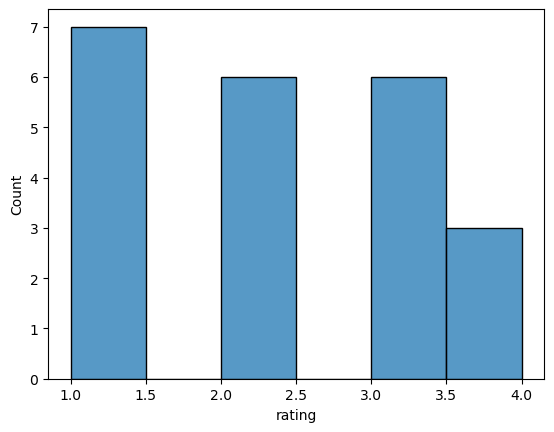

In [216]:
sns.histplot(data= constipation, x='rating');

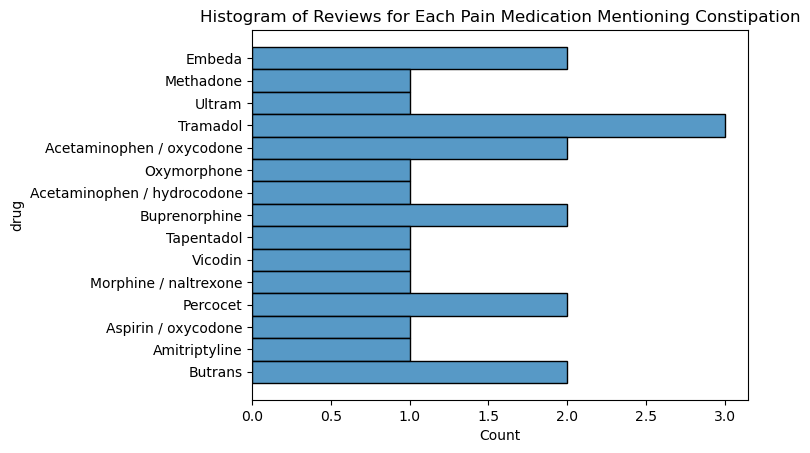

In [217]:
sns.histplot(data= constipation, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Constipation');

In [218]:
constipation.sample(5, random_state = 6789).values.tolist()

[['Ultram',
  '"I was prescribed this medicine for moderate pain after surgery. My incisions bothered me, and I took 4 pills a day for the first 3 days, then usually 2 a day. However, the side effects: nausea, palpitations, dizziness, drowsiness AND sleeplessness, constipation and mental vagueness were really too unpleasant to be rid of minor pain, so after a week I stopped taking it. It is annoying that after stopping it, I suffered nausea, palpitations, and weakness/drowsiness after large meals--possibly due to withdrawal."',
  3.0,
  26,
  'constipation'],
 ['Vicodin',
  '"Prescribed when I had all 4 wisdom teeth removed. This worked well on the first day at taking the pain away, but I was unable to sleep. After about the third dose severe nausea kicked in, as well as constipation and insomnia. "',
  3.0,
  4,
  'constipation'],
 ['Acetaminophen / hydrocodone',
  '"Prescribed when I had all 4 wisdom teeth removed. This worked well on the first day at taking the pain away, but I was 

The reviews above each note multiple side effects, include constipation. These reviews suggest it could be worthwhile to conduct/continue research into why some people have such extreme side effects, while others experience none.

I will move on to observe mentions of sleep difficulties.

##### Sleep

In [219]:
sleep = low[low['review'].str.contains('sleep')]

sleep

,drug,review,rating,usefulcount
1944,Belbuca,"""I was on Fentynal patches for year and a hal...",1.0,14
12790,Voltaren,"""Was given voltaren-XR for knee pain. I am st...",1.0,24
13818,Pregabalin,"""I really didn&#039;t notice much difference a...",3.0,14
14321,Nucynta,"""For fibromyalgia - This drug did absolutely n...",1.0,40
14323,Nucynta,"""I took 150 mg x 2 daily of nucynta for full b...",1.0,27
...,...,...,...,...
152750,Amitriptyline,"""I am currently 16 years old, and have chronic...",3.0,41
153144,Amitriptyline,"""I have been on a 75mg of Elavil for over a ye...",4.0,98
153157,Amitriptyline,"""I have tried Cymbalta, tramadol, gabapentin, ...",4.0,54
153159,Amitriptyline,"""This medication caused me to have very horrib...",1.0,43


There are 144 reviews containing the word "sleep", with ratings of less than 5.

In [220]:
#turning subset into a dataframe for later use & displaying top 5 rows

sleep = pd.DataFrame(sleep)

sleep['side_effect'] = 'sleep'

sleep.head()

,drug,review,rating,usefulcount,side_effect
1944,Belbuca,"""I was on Fentynal patches for year and a hal...",1.0,14,sleep
12790,Voltaren,"""Was given voltaren-XR for knee pain. I am st...",1.0,24,sleep
13818,Pregabalin,"""I really didn&#039;t notice much difference a...",3.0,14,sleep
14321,Nucynta,"""For fibromyalgia - This drug did absolutely n...",1.0,40,sleep
14323,Nucynta,"""I took 150 mg x 2 daily of nucynta for full b...",1.0,27,sleep


In [221]:
sleep.rating.mean()

1.9513888888888888

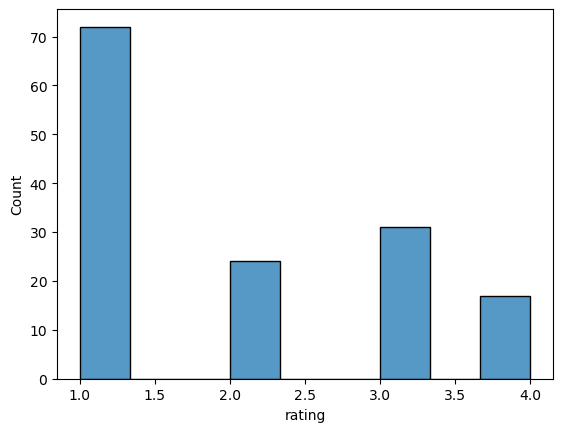

In [222]:
sns.histplot(data = sleep, x='rating');

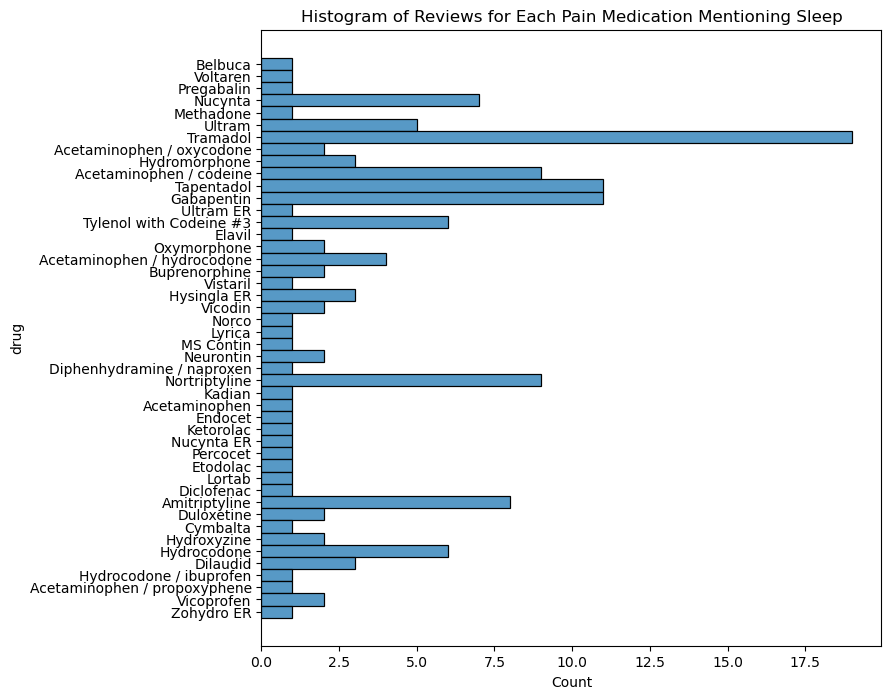

In [223]:
fig, ax = plt.subplots(figsize = (8,8))

sns.histplot(data= sleep, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Sleep');

In [224]:
sleep.sample(5, random_state = 6789).values.tolist()

[['Hydrocodone',
  '"24 hr medicine for pain, I only got 6 hours of minimal relief.  Started on the 20 mg for 1 month, then Dr switched me to 40 mg for 1 months, then 30 mg for 1 month.  It always seemed to start working long after I took it, about 12 hrs and made me extremely sleepy and tired, along with pain.  In the 3 months I took it, I gained 15 pounds without even eating more or differently because I was constantly nauseous with it.  Who wants food when queasy?  I have been prescribed and instant release pain med and have been on 2 days.  It works great with no side effects and I have lost the 7 lbs of the 15 the hysinglia  made me gain.  Hopefully the other 8 lbs will come off quickly too because the weight gain from the drug caused my A1C to go"',
  1.0,
  27,
  'sleep'],
 ['Ultram ER',
  '"My doctor prescribed ULTRAM ER 200 for lower back pain and sciatica.  I was taking 1 tablet twice a day.  For 2 or 3 days it seemed to work great.  Then I started having side effects.  I had

In the reviews above, there are reports of sleepiness/lethergy, and one report of sleep disturbances. Meanwhile, from the value counts above, it appears there are numerous drugs that may reference problems related to sleep.

I will move on to observe another potential side effect, which is difficulty breathing.

##### Breathing

In [225]:
breath = low[low['review'].str.contains('breath')]

breath.head()

,drug,review,rating,usefulcount
14379,Nucynta,"""Takes a while to feel any relief. I have exp...",3.0,27
14405,Nucynta,"""I was prescribed Nucynta for severe neck/shou...",1.0,20
25454,Fentanyl,"""At first patch helped with pain. Side effects...",1.0,10
28496,Acetaminophen / oxycodone,"""I&#039;ve been taking Endocet 10 mg for almos...",3.0,14
29777,Talwin Nx,"""Hydrocodone wasn&#039;t providing relief thro...",2.0,19


In [226]:
#turning subset into a dataframe for later use & displaying top 5 rows

breath = pd.DataFrame(breath)

breath['side_effect'] = 'breath'

breath.head()

,drug,review,rating,usefulcount,side_effect
14379,Nucynta,"""Takes a while to feel any relief. I have exp...",3.0,27,breath
14405,Nucynta,"""I was prescribed Nucynta for severe neck/shou...",1.0,20,breath
25454,Fentanyl,"""At first patch helped with pain. Side effects...",1.0,10,breath
28496,Acetaminophen / oxycodone,"""I&#039;ve been taking Endocet 10 mg for almos...",3.0,14,breath
29777,Talwin Nx,"""Hydrocodone wasn&#039;t providing relief thro...",2.0,19,breath


In [227]:
breath.shape

(27, 5)

In [228]:
breath.rating.mean()

1.962962962962963

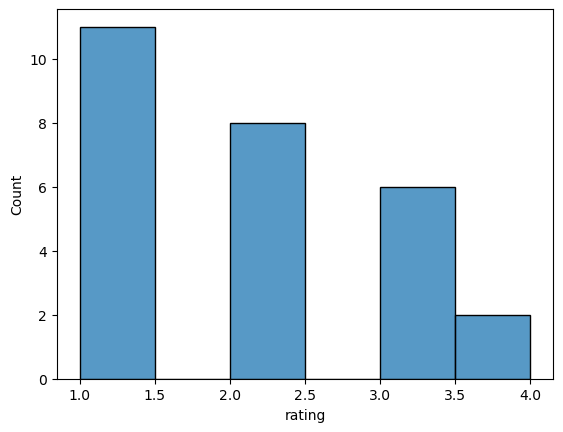

In [229]:
sns.histplot(data = breath, x='rating');

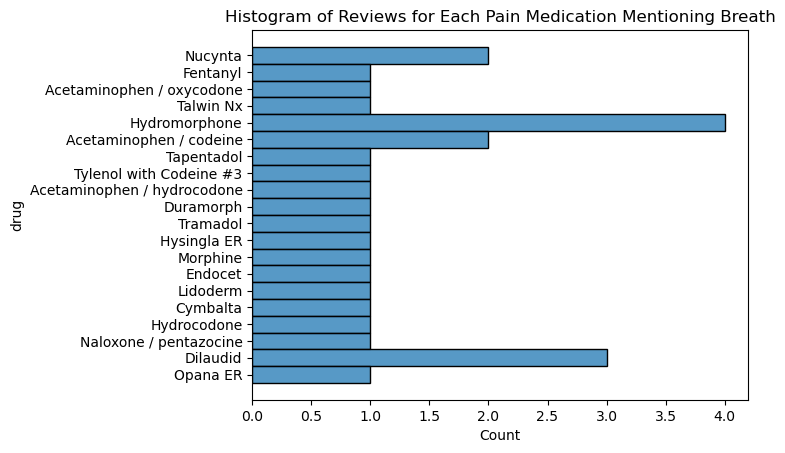

In [230]:
sns.histplot(data= breath, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Breath');

In [231]:
breath.sample(5, random_state = 6789).values.tolist()

[['Tapentadol',
  '"Takes a while to feel any relief.  I have experienced dizziness, shallow breathing, hypotention."',
  3.0,
  27,
  'breath'],
 ['Hydrocodone',
  '"I took 10mg, 3x day hydrocodone for a year prior to a new pain doc in a new state requiring I switch to Hysingla ER. I had only had one 10mg hydrocodone for each of the two days prior to beginning the Hysingla so this was not withdrawals. An hour after the 20mg pill, my heart was pounding hard, short of breath, which progressed to severe abdominal pain, nausea, the worst pain of my life (easily 2-3x my very worst days with stage 3 adhesive arachnoiditis, Ehlers-Danlos, and innumerable tarlov cysts on my spinal cord), joint pain, muscle pain and spasms, and I could literally feel my CSF pulsing in my spinal cord. The doc actually made me take a second dose because she thought I was in withdrawal. I vomited the 2nd one and nearly aspirated it"',
  1.0,
  0,
  'breath'],
 ['Lidoderm',
  '"The Mylan lidocaine patches are a wa

The Lidoderm review is actually commenting on the adhesion of the patches, however the other reviews do give descriptions of breathing problems. This is something patients should be aware of, in case they notice changes in their own breathing.

It occurs to me that not all sleepiness would be demonstrated through searching for "sleep" as in the previous example. I will next observe for mentions of drowsiness.

##### Drowsiness

In [232]:
drowsy = low[low['review'].str.contains('drows')]

drowsy

,drug,review,rating,usefulcount
18759,Ultram,"""I was prescribed this medicine for moderate p...",3.0,26
30349,Acetaminophen / codeine,"""Had a secondary molar extracted and was presc...",1.0,20
30353,Acetaminophen / codeine,"""Firstly it took me a while to fall asleep eve...",3.0,17
30393,Acetaminophen / codeine,"""I have needed to get my four wisdom teeth pul...",1.0,20
30411,Acetaminophen / codeine,"""I have had all 4 of my wisdom teeth removed 2...",1.0,20
34999,Gabapentin,"""I&#039;ve had 5 surgeries on lower back which...",3.0,85
37315,Tylenol with Codeine #3,"""I have had all 4 of my wisdom teeth removed 2...",1.0,20
37373,Tylenol with Codeine #3,"""Had a secondary molar extracted and was presc...",1.0,20
37376,Tylenol with Codeine #3,"""Firstly it took me a while to fall asleep eve...",3.0,17
39990,Acetaminophen / hydrocodone,"""Doesn&#039;t do anything. No nausea, drowsin...",1.0,14


In [233]:
#turns subset into a dataframe for later use & displays top 5 rows

drowsy = pd.DataFrame(drowsy)

drowsy['side_effect'] = 'drowsy'

drowsy.head()

,drug,review,rating,usefulcount,side_effect
18759,Ultram,"""I was prescribed this medicine for moderate p...",3.0,26,drowsy
30349,Acetaminophen / codeine,"""Had a secondary molar extracted and was presc...",1.0,20,drowsy
30353,Acetaminophen / codeine,"""Firstly it took me a while to fall asleep eve...",3.0,17,drowsy
30393,Acetaminophen / codeine,"""I have needed to get my four wisdom teeth pul...",1.0,20,drowsy
30411,Acetaminophen / codeine,"""I have had all 4 of my wisdom teeth removed 2...",1.0,20,drowsy


In [234]:
drowsy.shape

(22, 5)

In [235]:
drowsy.rating.mean()

1.8181818181818181

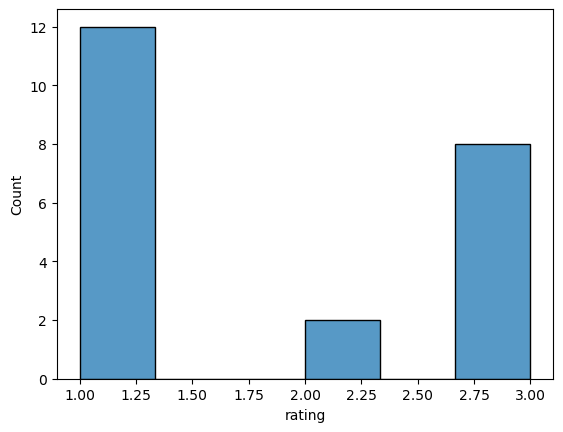

In [236]:
sns.histplot(data = drowsy, x='rating');

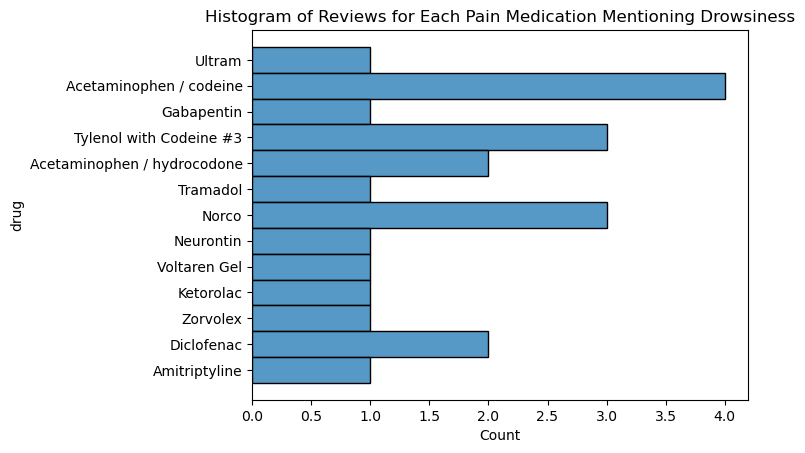

In [237]:
sns.histplot(data= drowsy, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Drowsiness');

In [238]:
drowsy.sample(5, random_state = 6789).values.tolist()

[['Acetaminophen / codeine',
  '"I have needed to get my four wisdom teeth pulled out for 2 years now. And just on this medication until surgery. My  mandible which is my lower jaw and gums are very swollen and infected not so much  pain in my upper areas in my mouth. My dentist prescribed me Tylenol #3 with codeine and antibiotics . Tylenol #3 is a joke it does not help with my pain at all it just makes me very drowsy. When I do rest the pain is still severe."',
  1.0,
  20,
  'drowsy'],
 ['Norco',
  '"This medication did not help my pain post surgery. My doctor had to change me to Percocet after 2 weeks. I even tried taking 2 at a time, with no relief. It was like there was no effect at all; I did not get drowsy so it did not help me sleep, it did not give me the jitters, or a &#039;high&#039; feeling. I cannot see how anyone would take these for recreational use or get addicted. They do absolutely nothing."',
  2.0,
  37,
  'drowsy'],
 ['Tylenol with Codeine #3',
  '"Firstly it took

There are 2 reviews in which patients say the reviewed drug did nothing, including that it did not cause drowsiness. The others do report drowsiness.

Meanwhile, the top two most frequent drugs in this subset are Acetaminophein/codeine, and Tylenol (also Acetaminophen) with Codeine 3; these drugs also among those reviewed in the samples above.

For my final side effect of interest, I will observe dizziness, inspired by the last sample review in this section.

##### Dizziness

In [239]:
dizzy = low[low['review'].str.contains('dizz')]

dizzy

,drug,review,rating,usefulcount
2890,Codeine,"""Had Panadeine Forte for a tooth abscess pain....",1.0,14
4048,Opana,"""I took ONE dose of 20mg of Opana ER. I becam...",1.0,50
14320,Nucynta,"""After 10 years of a combination of treatments...",1.0,29
14352,Nucynta,"""Gave me severe-headache,insomnia, dizzy, conf...",1.0,53
14379,Nucynta,"""Takes a while to feel any relief. I have exp...",3.0,27
...,...,...,...,...
135639,Hydrocodone / ibuprofen,"""My dentist prescribed Vicoprofen for pain fol...",1.0,8
141301,Indomethacin,"""I have severe tongue pain after a nerve was d...",4.0,7
143552,Vicoprofen,"""My dentist prescribed Vicoprofen for pain fol...",1.0,8
158639,Butrans,"""The patch started off a great alternative to ...",3.0,93


In [240]:
#turns subset into a dataframe for later & displays top 5 rows

dizzy = pd.DataFrame(dizzy)

dizzy['side_effect'] = 'dizzy'

dizzy.head()

,drug,review,rating,usefulcount,side_effect
2890,Codeine,"""Had Panadeine Forte for a tooth abscess pain....",1.0,14,dizzy
4048,Opana,"""I took ONE dose of 20mg of Opana ER. I becam...",1.0,50,dizzy
14320,Nucynta,"""After 10 years of a combination of treatments...",1.0,29,dizzy
14352,Nucynta,"""Gave me severe-headache,insomnia, dizzy, conf...",1.0,53,dizzy
14379,Nucynta,"""Takes a while to feel any relief. I have exp...",3.0,27,dizzy


In [241]:
dizzy.rating.mean()

1.943661971830986

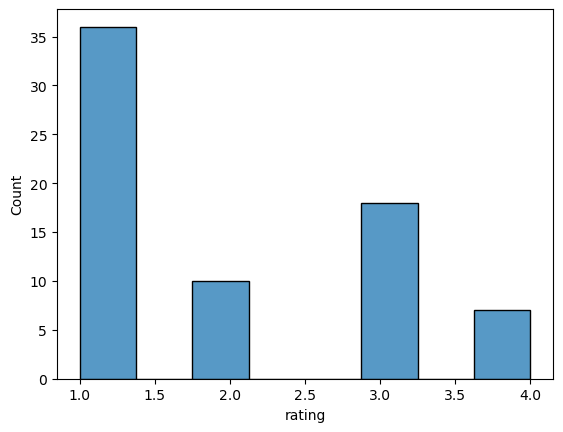

In [242]:
sns.histplot(data = dizzy, x='rating');

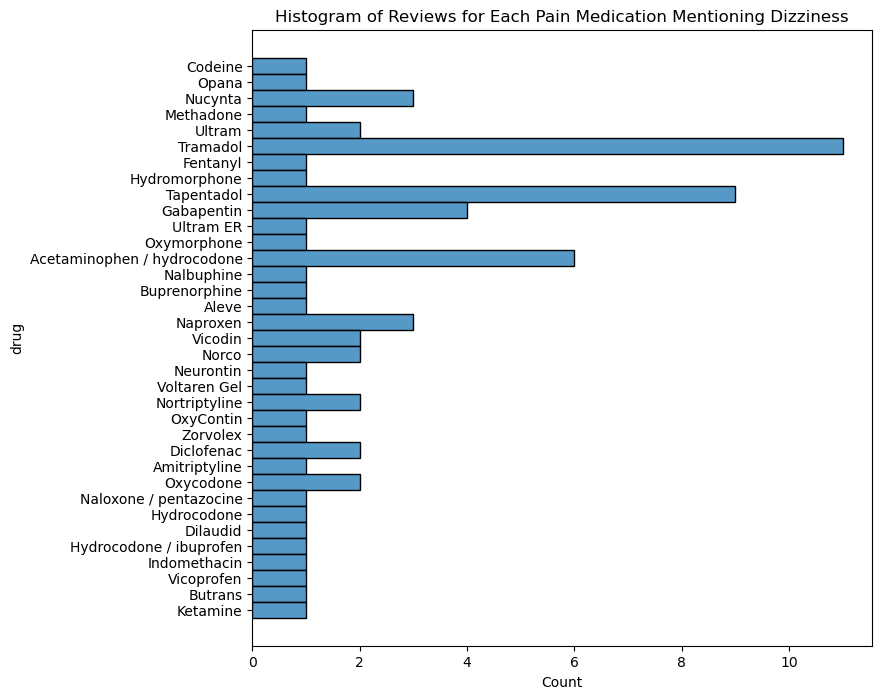

In [243]:
fig, ax = plt.subplots(figsize=(8,8))

sns.histplot(data= dizzy, y='drug').set(
    title = 'Histogram of Reviews for Each Pain Medication Mentioning Dizziness');

In [244]:
dizzy.drug.nunique()

35

In [245]:
dizzy.sample(5, random_state = 6789).values.tolist()

[['Acetaminophen / hydrocodone',
  '"Hello all, I had the worst experience of my life with medication with this prescription (hydrocodone-acetaphetomen 5-325). Now I took Vicodin years ago after I got in a bad car wreck, and it worked great. THIS IS NOT the same. I took this for getting a tooth pulled. I took one on the first night, no real relief. The next morning the gum is still bugging me, Pharmacist recommends I take 2. Within one hour I&#039;m spaced out sick, dizzy, and short of breath. I literally felt like I was going to die. I call the Pharmacist back who assures me it will pass, I don&#039;t need to go to an ER. So I wait it out,took 10 HOURS to pass. Scariest part being the shortness of breath.DO NOT TAKE THIS, I can&#039;t warn you enough. It is not the Vicodin of the past"',
  1.0,
  14,
  'dizzy'],
 ['Nortriptyline',
  '"After trying Tramadol, Oxycodone and Neurontin, I tried Nortriptyline for chronic back pain due to a herniated disc.  Unfortunately, after only a couple

There are 35 drugs represented in this subset, and 71 low reviews that reference dizziness. The sample reviews shown above do report problems with dizziness attributed to the drug being reviewed.

In my final work in analyzing side effects from pain medications, I will observe additional visualizations below.

### Visualizations

First, I will combine these subsets into one set for processing.

##### Creating the dataframe

In [246]:
side_effects = pd.concat([tolerance, withdrawal, nausea, hallucinations, suicidal, constipation, sleep, breath,
                          drowsy, dizzy])

side_effects.head()

,drug,review,rating,usefulcount,side_effect
14347,Nucynta,"""Was put on nucynta 100 mg every six hours for...",1.0,26,tolerance
23804,Tramadol,"""This pain reliever is not the best, but it he...",1.0,26,tolerance
30322,Acetaminophen / codeine,"""I have to take this following surgery to remo...",2.0,5,tolerance
30346,Acetaminophen / codeine,"""My wisdom tooth got infected(pericoronitis) a...",1.0,14,tolerance
30354,Acetaminophen / codeine,"""I was diagnosed with a missed miscarriage las...",1.0,11,tolerance


In [247]:
side_effects.shape

(471, 5)

There are 4613 reviews with mentions of the symptoms listed above.

I will create visualizations of the data below.

##### Distribution

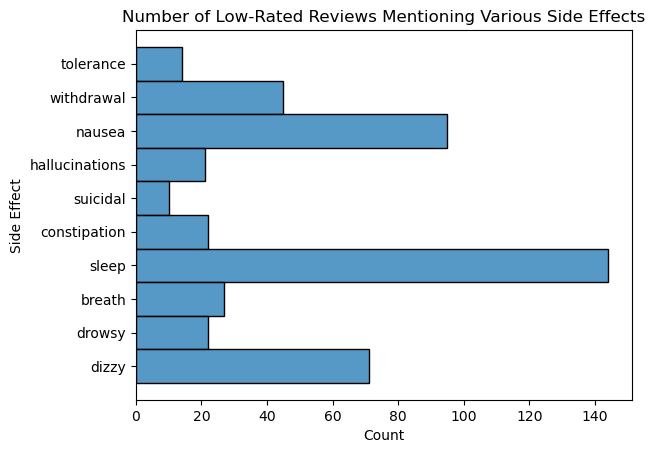

In [248]:
sns.histplot(data = side_effects, y='side_effect').set(
    title = 'Number of Low-Rated Reviews Mentioning Various Side Effects', ylabel = 'Side Effect');

We see that sleep is mentioned most commonly in this dataset of pain reviews with ratings of lower than 5.

*It should be noted that these words above were mentioned, but not necessarily that they were stated to be a problem. We did, however, see above that typically in this dataset of low reviews, these words are typically mentioned in description of a problem.*

I will move on to observe other characteristics of this dataset.

##### Average Rating

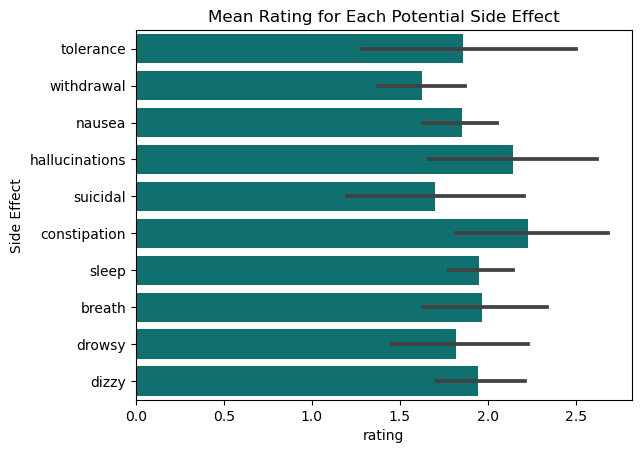

In [249]:
sns.barplot(data = side_effects, y='side_effect', x= 'rating', orient = 'h', color = 'teal').set(
    title = 'Mean Rating for Each Potential Side Effect', ylabel = 'Side Effect');

Those reviews mentioning withdrawal and suicidality have the lowest mean ratings.

*Still, we cannot determine with certainty that this is due to the potential side effects mentioned above. The information regarding these effects would need to be studied further, as not all mentions denote problems. It does, however, provide grounds for researching information regarding side effects which may occur with each drug.*

The next step could be to cluster reviews by rating and/or other attributes in order to see what commonalities and distinctions exist. In the next notebook, I use K-means in order to cluster the data for pain medications and all reviews.